# Integrated CA 2

### Table of Contents
### 1. Introduction
> ### 1.1 Libraries
> ### 1.2 Functions
### 2. Business Understanding
### 3. Module: Data Preparation
> ### 3.1
> ### 3.2
> ### 3.3
### 4. Module: Statistical Techniques
> ### 4.1
> ### 4.2
> ### 4.3
### 5. Module: Machine Learning
> ### 5.1
> ### 5.2
> ### 5.3

## 1. Introduction

Introduction...

#### 1.1 Libraries

In [1]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statistics as stats
from scipy import stats
#from scipy.stats import shapiro
import math

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import missingno as msno

from scipy.stats import chi2_contingency


from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression

#from sklearn.linear_model import LinearRegression, , ElasticNet, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("Employee_Attrition.csv")
df_orgnl = df.copy()

#### 1.2 Some functions used

In [3]:
### This class could still take more methods and be expanded.
class BaselineModelEvaluator():
    # initialisation
    def __init__(self, df, y, y2=None, classify=False):
        self.counter = 1
        # don't overwrite original
        self.df = df.copy()
        self.X = None
        self.y = y
        self.y2 = y2
        self.tar=None
        self.tar_string = None        
        
        # these will be assigned later
        self.encoder = LabelEncoder()
        self.imputer=imputer=SimpleImputer(strategy='mean')
        self.model=LinearRegression()
        self.model2=LogisticRegression()
        
        self.pca=None

        self.pipe = Pipeline([('imputer', self.imputer), ('model', self.model)])
        
        self.drop_second=False

        self.classify = classify
   
    def pipeline(self):
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.tar, test_size=0.2, random_state=659)
        
        # pipeline
        #pipe = self.pipeline
        #pipe = Pipeline([('imputer', self.imputer), ('model', self.model)])

        # impute in sequence
        # impute should only happen here and be skipped when pipeline is fitted next, as there will be no more missing values
        X_train_imputed = self.pipe.named_steps['imputer'].fit_transform(X_train)
        X_test_imputed = self.pipe.named_steps['imputer'].transform(X_test)
        #print(X_train_imputed.shape, X_test_imputed.shape)


        
        # Fit the model
        self.pipe.fit(X_train_imputed, y_train)

        #X_train_imputed_df = pd.DataFrame(X_train_imputed)
        #print(X_train_imputed_df.head())
       
        # predictions
        y_pred = self.pipe.predict(X_test_imputed)

        if self.regression == True:# this prints out r2 for classifier so needs to be examined
            # metrics
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
    
            # Print evaluation metrics
            print(f"{self.counter}. Baseline model for predicting {self.tar_string}")
            self.counter += 1
            print(f"Using: {self.model}, {self.imputer}, {self.encoder}")
            print(f"Drop second target = {self.drop_second}") # rephrase this
            print(f"Mean Squared Error (MSE): {mse}")
            print(f"R-squared (R2): {r2}")
            print("\n")

        elif self.regression == False:
            # Convert to categorical and round predictions
            y_test_cat = pd.Categorical(y_test)
            y_pred_rounded = y_pred.round().astype(int)

            
            # metrics
            #print("y_test: ", y_test)
            #print("y_pred: ", y_pred)
            accuracy = accuracy_score(y_test_cat, y_pred_rounded)
            # Print evaluation metrics
            print(f"{self.counter}. Baseline model for predicting {self.tar_string}")
            self.counter += 1
            print(f"Using: {self.model}, {self.imputer}, {self.encoder}")
            print(f"Drop second target = {self.drop_second}")
            print(f"Accuracy: {accuracy:.2f}")
            print("\n")
                
    #### missing categores should be handled here ####
    def encode_categories(self):
        # encoding categories
        categorical_columns = self.df.select_dtypes(include=['object']).columns.tolist()
        self.df = pd.get_dummies(self.df, columns=categorical_columns, dummy_na=True)


    def impute_targets(self):     
        # impute y with mean
        self.df[self.y] = self.df[self.y].fillna(self.df[self.y].mean())
        if self.y2:
            self.df[self.y2] = self.df[self.y2].fillna(self.df[self.y2].mean())
            
    def model_y(self):
        # model target
        self.tar = self.df[self.y]
        self.tar_string = self.y
        self.X = self.df.drop(self.y, axis=1)
        if self.drop_second == True:
            self.X = self.X.drop(self.y2, axis=1)
        self.pipeline()
        self.drop_second=False
    
    def model_y2(self):
        # model secondary target if there is one
        if self.y2 is not None:
            self.tar = self.df[self.y2]
            self.tar_string = self.y2
            self.X = self.df.drop(self.y2, axis=1)
            if self.drop_second == True:
                self.X = self.X.drop(self.y, axis=1)
            self.pipeline()
            self.drop_second = False
        else:
            pass
        
    def set_model(self, model=None, model2=None, imputer=None, encoder=None, pipe=None):
        # set modelling attributes
        # can add more stuff here
        if encoder is not None:
            self.encoder = encoder
        if imputer is not None:
            self.imputer = imputer
        if model is not None:
            self.model = model
        if model2 is not None: # use this model for classification as it is set later
            self.model = model2
        if pipe is not None:
            self.pipe = pipe

    def targets_as_cat(self):
        self.df[self.y] = self.df[self.y].round(0).astype(int)
        self.df[self.y] = pd.Categorical(self.df[self.y])
        try:
            self.df[self.y2] = self.df[self.y2].round(0).astype(int)
            self.df[self.y2] = pd.Categorical(self.df[self.y2])
        except:
            pass
        


    def baseline_models(self, title=""):
        # could form full title here
        if len(title) > 1:
            title = "for " + title
        
        title_string = f"Baseline models report {title}\n"
        print(title_string)
        # this method to run the different pipelines and parts of above model moved to init
        self.encode_categories()
        self.impute_targets() # mean impuation for targets, not used later when targets have no missing values

        self.regression = True
        # regression analysis
        self.model_y()
        self.drop_second=True
        self.model_y()
        if self.y2 is not None:
            self.drop_second=False
            self.model_y2()
            self.drop_second=True
            self.model_y2()

        self.regression = False
        # classification
        if self.classify == True:
            self.targets_as_cat()
            self.model = self.model2 # set classification model
            print("Report Part 2: Classification")
            self.drop_second=False
            self.model_y()
            self.drop_second=True
            self.model_y()
            if self.y2 is not None:
                self.drop_second=False
                self.model_y2()
                self.drop_second=True
                self.model_y2()
            
        

In [4]:
#baseline = BaselineModelEvaluator(df, "PerformanceRating", "JobSatisfaction", classify=True)
#baseline.baseline_models()

In [5]:
#baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=True)
#baseline.set_model(model=SVR())
#baseline.baseline_models()

In [6]:
# histogram
def histogram(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency",
              bins=10, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    sns.histplot(data=df, x=var, kde=False, bins=bins, color='green', ax=ax)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Histogram of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [7]:
# Boxplot
def boxplot(df, var, x_size=4, y_size=4, x_label="Values", y_label="Frequency", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(x_size, y_size))

    sns.boxplot(data=df, x=var, ax=ax, color='skyblue')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    title = f"Boxplot of {var}"
    ax.set_title(title)
    
    if ax is None:
        plt.show()

In [8]:
# printing statistical information out beside graph for analysis
# could possibly leave out boxplot from this and look at box plots together

def numerical_explore(df, var, bins=15, title=""):
    # 15 as default bins in histogram function
    
    # copy dataframe
    df1 = df.copy()

    # removing null values for graphing
    df1.dropna(subset=[var], inplace=True)
    # check for null values
    if df1[var].isnull().sum() > 0 : print(f"{var} contains null values.")

    # 3 plots each for now
    #fig, axs = plt.subplots(1,3, figsize=(13, 5))
    fig, axs = plt.subplots(1,3, figsize=(9, 3))
    
    # title
    if len(title) > 1:
        title = ", " + title
    
    fig.suptitle(f"Exploration of {var}{title}", fontsize=16)


    ### could do a table of results ###


    ### choose here if numeric or categorical
    # this should work
    if pd.api.types.is_numeric_dtype(df[var]):

        # maybe some descriptive statistics here
        #print(f"{var} is numeric")      

        # using 3 plots atm for numeric colums
        #fig, axs = plt.subplots(1,3, figsize=(13, 5))
        # title
        #fig.suptitle(f"Exploration of {var}", fontsize=16)
    
    
        # histogram
        axs[0] = histogram(df1, var, bins=bins, ax=axs[0])
    
        # shapiro-wilk test
        stat, p_value = stats.shapiro(df1[var])
        if p_value > 0.05:
            gaus ="Sample looks Gaussian (fail to reject H0)"
        else:
            gaus = f"""Sample does not look Gaussian (reject H0)
            p-value of {p_value}"""
    
        # generate statistical information
        statistics = f"""Statistical Information for {var}
        
        {df1[var].describe()}
        
        Range : {(df1[var].max()-df1[var].min())}
        IQR : {(df1[var].quantile(0.75)-df1[var].quantile(0.25))}
        
        Skew : {stats.skew(df1[var])}
        
        {gaus}"""
        
        
        # statistical information axis
        axs[1].text(0,1, statistics, ha="left", va="top", fontsize=8)
        axs[1].axis("off")
    
        # boxplot
        axs[2] = boxplot(df1, var, ax=axs[2])

    # this doesn't check any other condition as it's only two types of data being passed through this func
    else: # pd.api.types.is_categorical_dtype(df[var]):
        # possibly desc stats here too
        #print(f"{var} is categorical")

        # histogram
        axs[0] = histogram(df1, var, bins=bins, ax=axs[0])

        statistics = f"""Statistical Information for {var}

        {df1[var].value_counts()}"""
        

        # statistical information axis
        axs[1].text(0,1, statistics, ha="left", va="top", fontsize=8)
        axs[1].axis("off")

        # setting ax to blank
        axs[2].axis("off")
    
    # show plot
    plt.tight_layout() 
    plt.show()

In [9]:
# takes a list input
def drop_missing_from_target(df, target=["JobSatisfaction", "PerformanceRating"]):
    for i in target:
        df = df.dropna(subset=i)
    return df

In [10]:
### unused for now ### 
def basline_experiment(df, title="", context="", result="", classify=False):
    print("Title: " + title.capitalize() + "\n\n")

    print("Context:\n" + context + "\n\n")

    print("Result:\n" + result + "\n\n")


    
    
    data = df.copy()

    #### Imputation ####
    print("IMPUTATION TRIALS\n")

    # mean imputation
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    #baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', MinMaxScaler()),('model', baseline.model)]))
    baseline.set_model(imputer=SimpleImputer(strategy='mean'))
    baseline.baseline_models(title="Mean Imputation")
    
    # with KNNImputer
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(imputer=KNNImputer(n_neighbors=3))
    baseline.baseline_models(title="KNN Imputation")
    
    # with Iterative Imputer
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(imputer = IterativeImputer(max_iter=10, random_state=0))
    baseline.baseline_models()


    #### Scaling ####
    print("SCALING TRIALS\n")

    # standard scaler
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', StandardScaler()),('model', baseline.model)]))
    baseline.baseline_models(title="Standard Scaler")
    
    # min-max scaler
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('scaler', MinMaxScaler()),('model', baseline.model)]))
    baseline.baseline_models("Min-Max Scaler")


    #### Encoding ####
    print("ENCODING TRIALS\n")

    # one hot encoder
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(encoder=OneHotEncoder())
    baseline.baseline_models()


    #### Dimmensionality Reduction ####
    print("DIMENSIONALITY REDUCTION TRIALS\n")

    
    # with PCA
    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction", classify=classify)
    baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('pca', PCA(.995)),('model', baseline.model)]))
    baseline.baseline_models()
    
    # with LDA
    #baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction")
    #baseline.set_model(pipe = Pipeline([('imputer',baseline.imputer),('lda', LDA()),('model', baseline.model)]))
    #baseline.baseline_models()


    #### Modeling ####
    #print("MODELLING TRIALS\n")

    baseline = BaselineModelEvaluator(data, "PerformanceRating", "JobSatisfaction")
    baseline.set_model(model2=DecisionTreeClassifier())
    baseline.baseline_models()

In [11]:
def round_and_encode(df, cols):
    # removing decimals
    df[cols] = df[cols].round(0)#.astype(int) # maybe convert to int alone does this
                                             # but may round up or do something else
    
    # Convert 'Over18' column to categorical
    df[cols] = df[cols].astype('object')

    return df

## 2. Business Understanding

Integrated CA with three main tasks: Data Prep, Statistics, Machine Learning

Data prep: The objective is to investigate the influence of data preparation techniques.
Appropriate data preparation techniques and rational, including visualisations.

Stats: Investigate interesting relationships in the data
Statistical exploration of the data

Machine Learning: Model the data.
A model is a representation of the data. The business targets may not be appropriate to 



## 3. Module: Data Preparation

### 3.1 Characterisation of the data set: size; number of attributes; has/does not have missing values, number of observations etc.

In [12]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


In [13]:
df.shape

(1470, 35)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1323.0,36.635268,9.882161,14.544608,29.624982,34.951950,42.748741,69.402515
DailyRate,1323.0,802.030050,414.031025,86.828045,456.479553,782.958705,1130.577949,1784.394456
DistanceFromHome,1323.0,9.091097,8.177870,0.750112,2.147069,6.920808,13.584900,33.684424
Education,1323.0,2.923447,1.072203,0.770362,2.122706,3.015658,3.700560,6.285161
EmployeeCount,1323.0,0.999325,0.099656,0.628985,0.931146,0.998949,1.067371,1.290613
EmployeeNumber,1323.0,1026.679166,610.480802,1.054148,501.854842,1022.025017,1533.811096,2530.919375
EnvironmentSatisfaction,1323.0,2.726443,1.129679,0.759655,1.894818,2.887313,3.676600,5.254672
HourlyRate,1323.0,65.647722,21.469709,23.855272,47.701897,64.934490,83.038355,123.200439
JobInvolvement,1323.0,2.743028,0.765568,0.722008,2.177638,2.859143,3.179128,5.241968
JobLevel,1323.0,2.058270,1.127018,0.715172,1.045228,1.936150,2.609707,5.942269


In [15]:
df.describe(include="object").T

,count,unique,top,freq
Attrition,1323,2,No,1065
BusinessTravel,1323,3,Travel_Rarely,890
Department,1323,3,Research & Development,824
EducationField,1323,6,Life Sciences,504
Gender,1323,2,Male,783
JobRole,1323,9,Sales Executive,281
MaritalStatus,1323,3,Married,596
Over18,1323,1,Y,1323
OverTime,1323,2,No,929


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1323 non-null   float64
 1   Attrition                 1323 non-null   object 
 2   BusinessTravel            1323 non-null   object 
 3   DailyRate                 1323 non-null   float64
 4   Department                1323 non-null   object 
 5   DistanceFromHome          1323 non-null   float64
 6   Education                 1323 non-null   float64
 7   EducationField            1323 non-null   object 
 8   EmployeeCount             1323 non-null   float64
 9   EmployeeNumber            1323 non-null   float64
 10  EnvironmentSatisfaction   1323 non-null   float64
 11  Gender                    1323 non-null   object 
 12  HourlyRate                1323 non-null   float64
 13  JobInvolvement            1323 non-null   float64
 14  JobLevel

In [17]:
df.isnull().sum()

Age                         147
Attrition                   147
BusinessTravel              147
DailyRate                   147
Department                  147
DistanceFromHome            147
Education                   147
EducationField              147
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                      147
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                     147
JobSatisfaction             147
MaritalStatus               147
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
Over18                      147
OverTime                    147
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears           147
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtC

In [18]:
# missing data seems like 10 random data points from each column?
df.isnull().head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False


<Axes: >

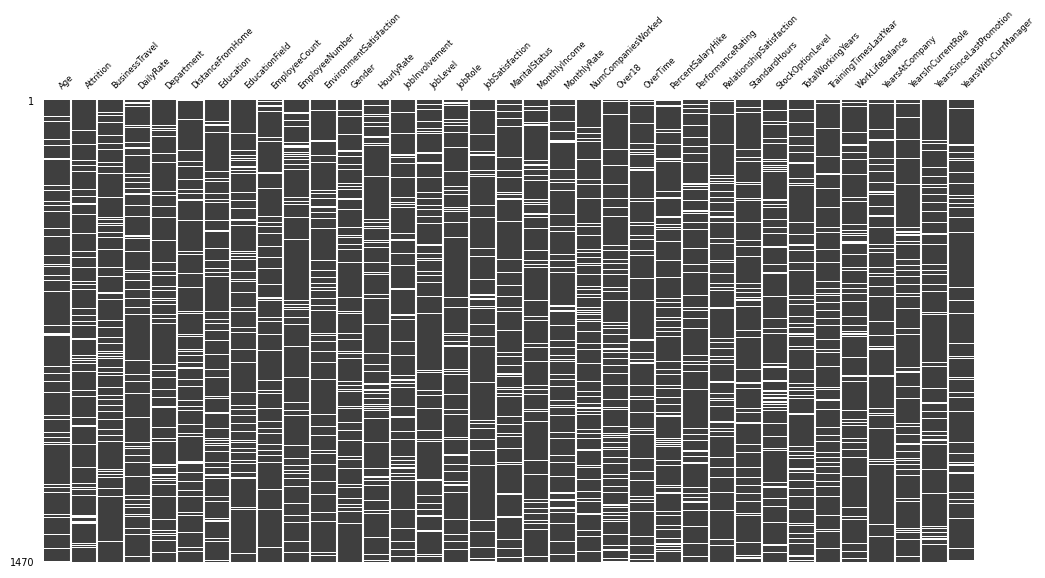

In [19]:
msno.matrix(df, sparkline=False, figsize=(12,6), fontsize=6)

In [20]:
# rows with no missing data
_ = df.dropna()
_.shape

(40, 35)

### 3.2. Application of Data preparation/evaluation methods (Cleaning, renaming, etc) and EDA (Exploratory Data Analysis) visualizations (plural), including a clear and concise explanation of your rationale for what you are doing with the data and why you are doing it.

In [21]:
# features are investigated here
print("Numerical: {}".format(len(df.select_dtypes(include='number').columns)-2))
print("Categories: {}".format(len(df.select_dtypes(include='object').columns)))

Numerical: 24
Categories: 9


In [22]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [23]:
### this loop prints out all the graphs for each individual feature
### they are all discussed in detail below so the loop is commented out
### otherwise it gets messy with graphs and repeated information
### this was technically the data exploration of all the features before data prep but it is sort of presented together

# loop through each feature
#for i in df.columns:
#    numerical_explore(df, i)

#### Correlations

In [24]:
correlation_matrix = df.select_dtypes(include=['number'])
correlation_matrix.corr().shape

(26, 26)

In [25]:
# looking through the numbers is unintuitive
correlation_matrix.corr()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.003115,-0.004483,0.218413,-0.012545,-0.003796,-0.011972,0.027241,0.023650,0.467031,...,0.025094,0.002155,0.042739,0.625620,-0.021116,-0.035865,0.273534,0.179098,0.183958,0.183590
DailyRate,0.003115,1.000000,-0.004227,-0.012328,0.009567,-0.050564,0.019894,0.031691,0.051141,-0.013380,...,0.019652,-0.040108,0.007044,0.013766,-0.009000,-0.035260,-0.038210,0.007122,-0.022840,-0.039930
DistanceFromHome,-0.004483,-0.004227,1.000000,0.012109,0.005865,0.035067,-0.030355,0.026033,-0.005980,0.023336,...,0.024771,-0.002562,0.039794,0.004308,-0.047087,-0.017814,0.023940,0.020311,-0.005743,0.033454
Education,0.218413,-0.012328,0.012109,1.000000,-0.037297,0.035267,0.007502,0.003187,0.033630,0.106218,...,-0.019207,0.010267,0.008528,0.147655,-0.034722,-0.004356,0.075283,0.072572,0.050648,0.065608
EmployeeCount,-0.012545,0.009567,0.005865,-0.037297,1.000000,0.063013,0.026024,0.056652,-0.039578,0.004059,...,0.015579,-0.003399,-0.038158,0.002776,-0.054455,-0.004015,0.018562,0.016204,-0.004410,-0.033018
EmployeeNumber,-0.003796,-0.050564,0.035067,0.035267,0.063013,1.000000,0.040412,0.003557,-0.016547,-0.004218,...,-0.072664,0.000358,0.063318,-0.019994,-0.006759,0.020873,-0.002520,-0.017335,-0.008418,-0.020842
EnvironmentSatisfaction,-0.011972,0.019894,-0.030355,0.007502,0.026024,0.040412,1.000000,-0.037906,-0.022821,0.007245,...,0.025902,-0.018980,-0.001693,-0.012346,-0.029385,0.037832,-0.021525,-0.001210,-0.000513,-0.051181
HourlyRate,0.027241,0.031691,0.026033,0.003187,0.056652,0.003557,-0.037906,1.000000,0.031025,-0.010295,...,0.003273,-0.017825,0.031599,0.047688,-0.030968,-0.016889,0.037367,-0.005881,0.008520,0.014796
JobInvolvement,0.023650,0.051141,-0.005980,0.033630,-0.039578,-0.016547,-0.022821,0.031025,1.000000,-0.008527,...,0.003356,0.003931,0.008476,0.012578,-0.033358,-0.023270,0.000706,0.032181,0.022490,0.046256
JobLevel,0.467031,-0.013380,0.023336,0.106218,0.004059,-0.004218,0.007245,-0.010295,-0.008527,1.000000,...,0.023036,0.043070,0.017891,0.756814,-0.038575,0.041841,0.494295,0.365519,0.349137,0.357980


correlation shape: (26, 26)


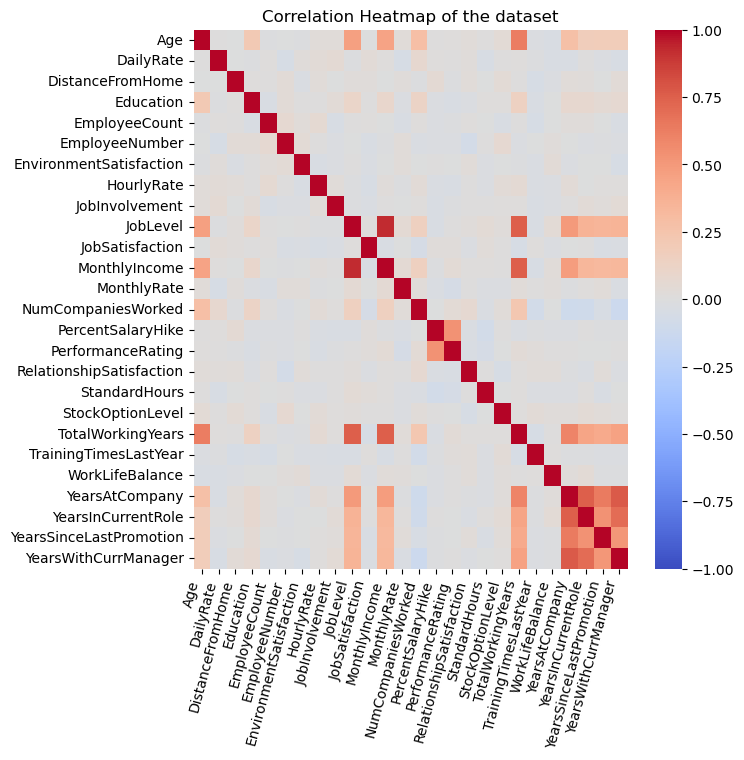

In [26]:
# correlation is easier to view in a larger number of features like this
# correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
print(f"correlation shape: {correlation_matrix.shape}")

# correlation heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=75, ha='right')
plt.title('Correlation Heatmap of the dataset')
plt.show()

In [27]:
# from above, monthly income and job level are highly correlated
df.MonthlyIncome.corr(df.JobLevel)

0.9235098140677838

In [28]:
# total working years is correlated with some features too
print("Correlations of TotalWorkingYears")
print("vs. JobLevel: ", df.TotalWorkingYears.corr(df.JobLevel))
print("vs. MonthlyIncome: ", df.TotalWorkingYears.corr(df.MonthlyIncome))
print("vs. YearsAtCompany: ", df.TotalWorkingYears.corr(df.YearsAtCompany))

Correlations of TotalWorkingYears
vs. JobLevel:  0.7568136270833515
vs. MonthlyIncome:  0.757637022403104
vs. YearsAtCompany:  0.593883740319838


In [29]:
# the last 4 columns are correlated together
# they are all related to years working
df.iloc[:,-4:].corr()

,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
YearsAtCompany,1.000000,0.753423,0.639672,0.767222
YearsInCurrentRole,0.753423,1.000000,0.532027,0.702790
YearsSinceLastPromotion,0.639672,0.532027,1.000000,0.509521
YearsWithCurrManager,0.767222,0.702790,0.509521,1.000000


In [30]:
# maybe run this at end or delete it
# it doesn't show any more information than the correlation heatmap does
#sns.pairplot(df.select_dtypes(include=['number']))

<Axes: xlabel='BusinessTravel', ylabel='count'>

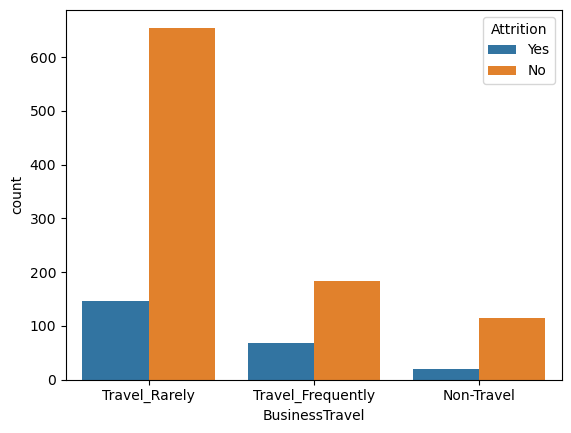

In [31]:
sns.countplot(x='BusinessTravel', data=df, hue= "Attrition")

In [32]:
df.Attrition.value_counts()

Attrition
No     1065
Yes     258
Name: count, dtype: int64

### Data Preparation

In [33]:
# Now that data exploration has been employed and baseline models have been created data preparation will be done

#### Age

In [34]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


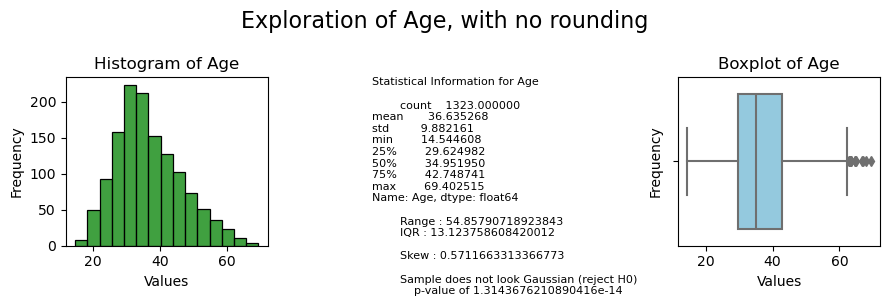

In [35]:
numerical_explore(df, "Age", title="with no rounding")

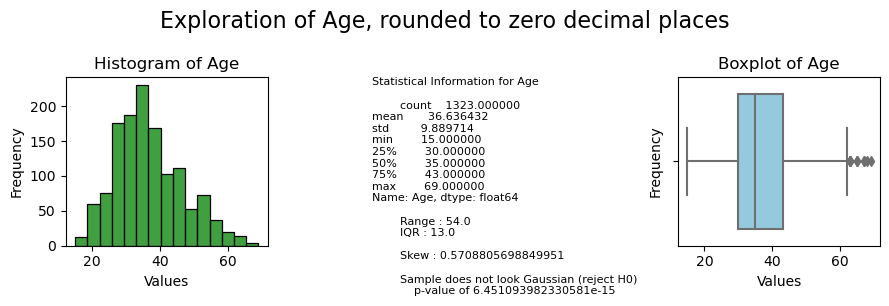

In [36]:
## Rounding age to 0 decimal places changes the shape of the original data,
## while it's not ideal to deal with 
df1=df.copy()
df1["Age"] = df.Age.round(0)
numerical_explore(df1, "Age", title="rounded to zero decimal places")

In [37]:
## round age to 1 decimal place keeps the data shape with less disruption to the skew
df1.Age = df.Age.round(1)

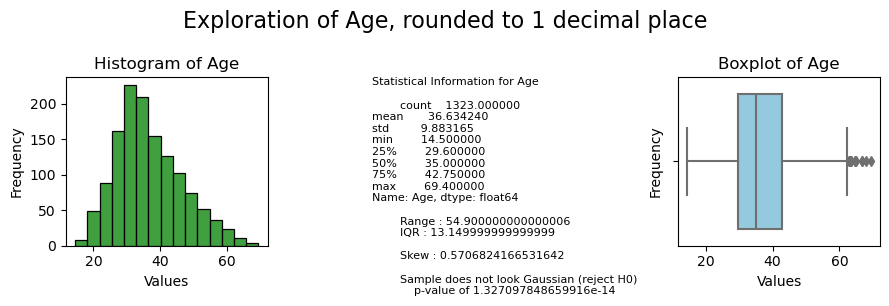

In [38]:
numerical_explore(df1, "Age", title="rounded to 1 decimal place")

In [39]:
# it seems unusual to use decimal places in age it has some functions:
# 1. keeps the signal in the data: the data differentiated between different 16s etc. (this may not be useful)
# 2. keeps the shape of the data
df1.Age

0       41.9
1       51.6
2       33.1
3       34.7
4       24.8
        ... 
1465    37.4
1466    35.0
1467    26.9
1468     NaN
1469    38.1
Name: Age, Length: 1470, dtype: float64

#### Age vs Over 18

In [40]:
# Over18 is if the employee is over 18, it only features yes values
# while some of the ages are as low as 16
# it makes this column unusable in two ways, first it is a constant value, second it is wrong information
df["Over18"].value_counts()

Over18
Y    1323
Name: count, dtype: int64

In [41]:
df1 = df[df["Age"] < 18]
df1[["Age", "Over18"]].head(50)

,Age,Over18
206,16.057972,NaN
498,16.792547,Y
828,16.741273,Y
853,16.789596,Y
972,14.544608,Y
1153,16.840129,Y
1197,17.109549,Y


In [42]:
# It leads to some questions either Age or Over18 is encoded wrongly
# Several trains of thought are available:
# 1. drop Over18: remove it as it provides no signal as is
# 2. reencode Over18: fix the feature.. but as only 7 values will be N it will be so unbalanced to be unusable
# 3. drop the ages below 18: the data seemed to consider them all 18, so remove the conflicting data
# 4. replace the ages below 18 with 18: setting the low ages to the new lower limit of the data might be viable as they aren't outliers
print(f"Number of ages lower than 18: {len(df1)}")

Number of ages lower than 18: 7


#### Age vs Year variables

In [43]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


In [44]:
df.JobRole.unique()

array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       nan, 'Healthcare Representative', 'Manufacturing Director',
       'Manager', 'Sales Representative', 'Research Director',
       'Human Resources'], dtype=object)

In [45]:
# to help make the decision more exploration is needed
# looking at age with the year variables reveals the data needs even further clearning
# for reference: the years variables are all continuous and not one of the ranking variable candidates

# employess have worked at the company at ages that may not align with the company job roles provided


# selecting age 
_ = df.iloc[:, 0]
# selecting year features
df1 = df.iloc[:, -4:]
df1 = pd.concat([_, df1], axis=1)

# selecting total working years
_ = df["TotalWorkingYears"]
df1 = pd.concat([df1, _], axis=1)

# sort by age ascending
df1 = df1.sort_values(by="Age")
df1.head(10)

,Age,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalWorkingYears
972,14.544608,0.000000,0.000000,0.000000,0.000000,0.000000
206,16.057972,3.551193,2.008697,NaN,2.360856,4.308867
828,16.741273,0.000000,0.000000,0.000000,0.000000,0.000000
853,16.789596,1.104673,1.060756,0.000000,0.000000,0.960555
498,16.792547,2.236441,NaN,2.069399,2.338651,2.950239
1153,16.840129,0.000000,0.000000,0.000000,NaN,0.000000
1197,17.109549,1.763690,2.107599,0.000000,1.684820,2.227287
149,18.067474,0.896289,0.000000,0.000000,0.000000,1.037603
177,18.269878,0.993286,0.000000,1.058821,0.000000,1.208996
727,18.292187,0.000000,NaN,0.000000,0.000000,0.000000


In [46]:
# looking at the employee that has worked at the company since 12 and a half years old
# he is nearly 17 and works in the human resources department as a reseach scientist and divorced....
# his education is null.. no doubt it's off the chart T_t
# it seems the data isn't just sparse but quite dirty
df.iloc[206]

Age                                  16.057972
Attrition                                   No
BusinessTravel                   Travel_Rarely
DailyRate                          1064.715525
Department                     Human Resources
DistanceFromHome                      3.803029
Education                                  NaN
EducationField                             NaN
EmployeeCount                         1.075091
EmployeeNumber                      289.315228
EnvironmentSatisfaction               3.990697
Gender                                    Male
HourlyRate                            65.18559
JobInvolvement                        4.135275
JobLevel                              1.060848
JobRole                     Research Scientist
JobSatisfaction                       2.070945
MaritalStatus                         Divorced
MonthlyIncome                      2335.718589
MonthlyRate                       12927.008434
NumCompaniesWorked                    0.985561
Over18       

#### Closer look at the year features

In [47]:
# wanted to look at these last..
# running some checks to make sure they at least make logical sense
# it may be that much of the data isn't usable

In [48]:
df1.describe()

,Age,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalWorkingYears
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000
mean,36.635268,6.933624,4.233363,2.160710,4.117695,11.426152
std,9.882161,6.046798,3.658111,3.221481,3.594053,8.075870
min,14.544608,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.624982,2.673269,1.824392,0.000000,1.687177,5.953221
50%,34.951950,5.422160,2.968874,0.967140,2.939240,9.306742
75%,42.748741,9.238005,7.052591,2.586631,6.987964,15.324548
max,69.402515,36.848408,19.091844,17.273662,19.976003,47.641892


In [49]:
# performing this one test reveals these features are all quite dirty..
# just this view alone shows YearsInCurrentRole and YearsWithCurrManager greater than TotalWorkingYears...
# ... YearsSinceLastPromotion should be conflicting with YearsInCurrentRole and TotalWorkingYears in the first row...

# Is years with current manager greater than total working years for any cases?
# this is something that could make modelling difficult..
# the year variables seem to be approximating ranges that would be expected so the decimals can't really be understood as a scaling
df1 = df[df["TotalWorkingYears"] < df["YearsWithCurrManager"]]
df1.iloc[:, -7:].head()

,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
5,6.694851,1.871592,2.046544,6.092499,8.389254,3.131537,7.060896
37,1.706644,3.041704,2.614786,1.898107,2.100594,NaN,1.969773
51,2.025175,3.330482,NaN,1.899158,1.957240,NaN,2.068893
143,3.990013,3.992088,1.779493,NaN,3.410918,0.000000,4.166408
164,0.887973,2.232780,2.222138,0.986038,1.162819,0.000000,1.068507


#### Investigating Noise with feature engineering

In [50]:
# seems a different technique was applied to the dataset for random noise.. which was kind of suspected
# if more views are done as above it'll probably yield more of the same out of sync years
# the data could be rounded and the noise may be removed but the characteristic of the noise lost

In [51]:
# years at company can be off by upto 7 years (both features with noise in opposite direction likely here)
# 

# can only see the noise here that does not make logical sense
# more noise likely exists, first in the opposite direction and this isn't a strict science

# 214 entries have YearsAtCompany greater than TotalWorkingYears
# rounding the 
df1["Y1"] = df1["TotalWorkingYears"] - df1["YearsAtCompany"]
below_zero_values = df1[df1["Y1"] < 0]["Y1"]
print(len(below_zero_values))
below_zero_values.describe()

16


count    16.000000
mean     -0.353464
std       0.285252
min      -0.952496
25%      -0.638561
50%      -0.202356
75%      -0.138952
max      -0.042265
Name: Y1, dtype: float64

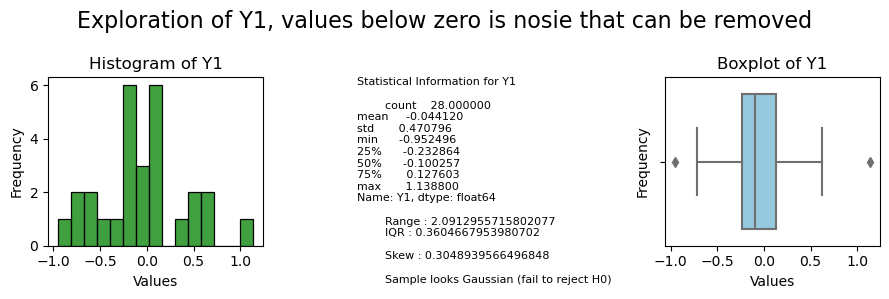

In [52]:
numerical_explore(df1, "Y1", title="values below zero is nosie that can be removed")

In [53]:
# these aren't as out of sync as YearsAtCompany...
# ... more than likely because the range of YearsInCurrentRole is lower...
# ...so the out of sync years is revealed less often
df1["Y1"] = df1["TotalWorkingYears"] - df1["YearsInCurrentRole"]
below_zero_values = df1[df1["Y1"] < 0]["Y1"]
print(len(below_zero_values))
below_zero_values.describe()

11


count    11.000000
mean     -0.819315
std       0.774495
min      -2.580717
25%      -1.108852
50%      -0.447141
75%      -0.324832
max      -0.129331
Name: Y1, dtype: float64

In [54]:
# so what can be done with years variables
# 1. lengthened where makes logical sense
# 2. shortened where makes logical sense
# 3. binned in categories

# although one question should be asked:
# generally a high number will be still a high number, and a low number still low...
# ...and while the data is less truthful or logical is it less useable for modelling?

# looking again at entry 206, if the years variables were cleaned with python the employee...
# ...would be now an 18 year old (set to 18) Human Resources, Research Scientist that worked with the company...
# ... for 4 years (rounded up), 4 total working years (rounded down), in current role for 2 years, with current manager for 2 years...
# ... while the work years aren't badly out of sync here there are still some questions raised when they are rounded.

# back to the question... will any of this effect modelling, if low number is still low etc, and the data will be scaled anyway

# my main issue with it is the level of precision, it is first a level of precision that shouldn't have been (or wasn't) recorded
# and rounding leaves the data with logical questions, it makes binning the values an attractive option

# binning shouldn't be a loss of signal and may circumvent the issue with noise a bit
# it's likely that the target features need coverted to ordinal categories so again back to precision:
# modelling with binned categories should yield the same post modelling evaluation that certain features
# impact negatively or positively (or don't) the target features.

In [55]:
df.iloc[206]

Age                                  16.057972
Attrition                                   No
BusinessTravel                   Travel_Rarely
DailyRate                          1064.715525
Department                     Human Resources
DistanceFromHome                      3.803029
Education                                  NaN
EducationField                             NaN
EmployeeCount                         1.075091
EmployeeNumber                      289.315228
EnvironmentSatisfaction               3.990697
Gender                                    Male
HourlyRate                            65.18559
JobInvolvement                        4.135275
JobLevel                              1.060848
JobRole                     Research Scientist
JobSatisfaction                       2.070945
MaritalStatus                         Divorced
MonthlyIncome                      2335.718589
MonthlyRate                       12927.008434
NumCompaniesWorked                    0.985561
Over18       

#### Back to Age

In [56]:
df1 = df.copy()  
df1.loc[df1["Age"] < 18, "Age"] = 18

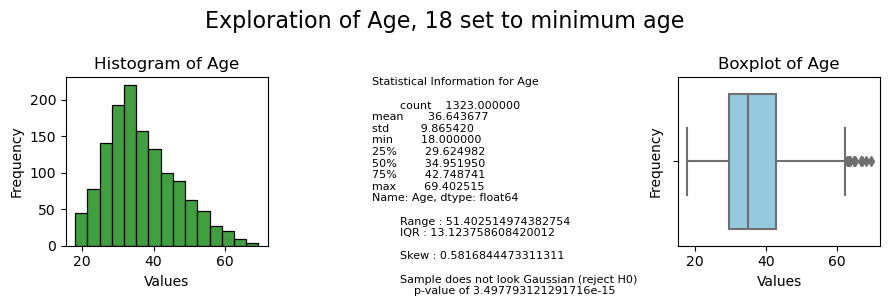

In [57]:
numerical_explore(df1, "Age", title="18 set to minimum age")

In [58]:
# Age looks log normal but when log transformation is applied it does look more normal...
# ...but rejects the null hypothesis for testing if it was a sample from a normal population
# age wouldn't be expected to be log normal.. normality would be expected for natural biological attributes...
# ... but it was a quick trial to perform as it looked like it could have been
# 
_ = df1.copy()
_['Age'] = np.log(_['Age'])

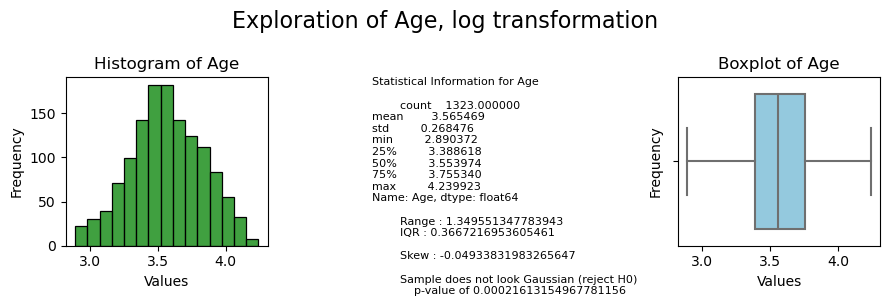

In [59]:
numerical_explore(_, "Age", title="log transformation")

In [60]:
# standardisation and min-max scaling do keep the shape of course
scaler = MinMaxScaler()
_ = df1.copy()
_['Age'] = scaler.fit_transform(_['Age'].values.reshape(-1, 1))

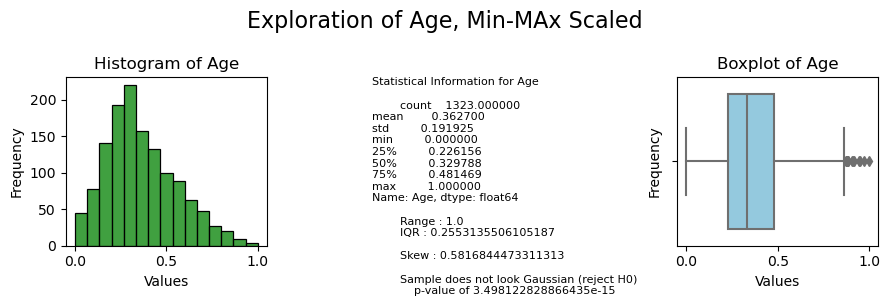

In [61]:
numerical_explore(_, "Age", title="Min-MAx Scaled")

In [62]:
scaler = StandardScaler()
_ = df1.copy()
_['Age'] = scaler.fit_transform(_['Age'].values.reshape(-1, 1))

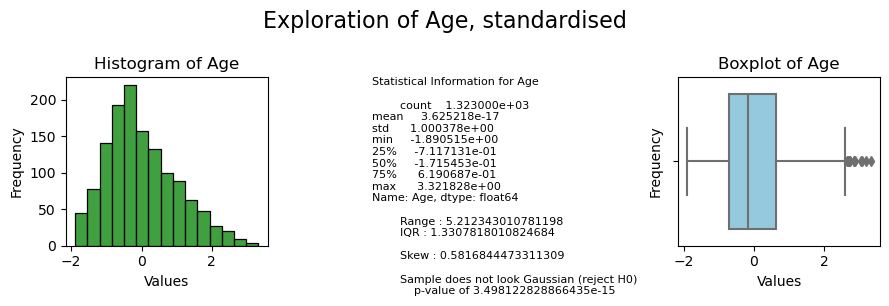

In [63]:
numerical_explore(_, "Age", title="standardised")

In [64]:
# Age isn't normal distributed as it isn't ages selected from the population of people
# it is ages sampled from employees of this company which attracts mainly 30-43 year olds, ie only working age people

# it's an assumption that the population of peoples ages is normally distributed.
# considering that it may be, the selection of employees is akin to a bad sampling technique of the total population of people
# and gives a biased sample that isn't representive of the population as a whole

# given that it looks close to normal, and the assumptions above, it's fair to assume that the ages represent close to the real age
# of the employees possibly with noise added again, while the Over18 feature hinted that some ages may be recorded wrong, or the data
# is dirty, there aren't a selection of features that can be used to examine just how much noise exists in the feature, like was approximated with year features

# repeating the question from earlier:
# Several trains of thought are available:
# 1. drop Over18: remove it as it provides no signal as is
# 2. reencode Over18: fix the feature.. but as only 7 values will be N it will be so unbalanced to be unusable
# 3. drop the ages below 18: the data seemed to consider them all 18, so remove the conflicting data
# 4. replace the ages below 18 with 18: setting the low ages to the new lower limit of the data might be viable as they aren't outliers

# now that years have been examined and the data further illuminated makes the decision easier.
# the following decisions on age will be made:
# 1. Over18 should be dropped; it provides no signal as it is a static variable

# 2. Ages below 18 should be set to 18, only 7 values are below 18 and while it's likely 
# an employee below 18 exists it would be a negligable outlier and not interesting to modelling at this level

# 3. Age should be rounded to one decimal place, to remove some of the not needed 'precision' but keep the majority of the noise
# while it could be rounded to no decimal places and make the feature seem more 'right'... it would be doubling down on adding noise to the data
# think trying to encode a digital file into a higher format using a low quality copy 

#### Drop Over18

In [65]:
# Over18 isn't usable, it is one value each non null entry
df = df.drop(["Over18"], axis=1)
df.shape

(1470, 34)

#### Formating Age and Year Features

In [66]:
# format them now as years aren't usable for anova
### TODO ###
# format age
# visualise different categories with age
# test different categories with age
# do more features
# remember! no features showed linear relationship with target features

In [67]:
df1 = df.copy()
df1.shape # only missing Over18 so far

(1470, 34)

In [68]:
# formatting age
df["Age"] = df["Age"].round(1)
df.loc[df["Age"] < 18, "Age"] = 18
df.Age.min()

18.0

In [69]:
# formatting year features
year_features = ["TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole",
           "YearsSinceLastPromotion", "YearsWithCurrManager"]


In [70]:
# making test dataframe 
year_features.insert(0, "Age")
year_features.append("PerformanceRating")
year_features.append("JobSatisfaction")
df1 = df1[year_features]
df1.head()

,Age,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobSatisfaction
0,41.920786,8.063833,5.795945,3.993896,0.000000,4.594972,2.844897,3.397665
1,51.589037,8.965059,10.070232,7.937505,1.032295,5.901207,4.120281,1.584059
2,33.131540,8.427238,0.000000,0.000000,0.000000,0.000000,2.781168,3.301009
3,34.707073,7.662606,8.435324,5.563667,2.845429,0.000000,2.769576,3.220844
4,24.790188,6.241733,2.040124,1.970786,2.495949,2.219353,3.282183,1.697330


In [71]:
# before binning the year features it's important to remember they all have outliers
# for binning it may be adequte to do bins of 5 years until the outliers and do 20+ for the remaining
# for eg. the logic being that for TotalWorkingYears could be binned in 10 5 year bins, or every 5 years until
# 20 to cover the 75% percentile and the remaning outliers grouped together as 20+
# when we count the data points above 30 and 40 for this variable we get 49 and 6 respectively
# this is still a low amount of signal in this last bin comparitive to the size of the data

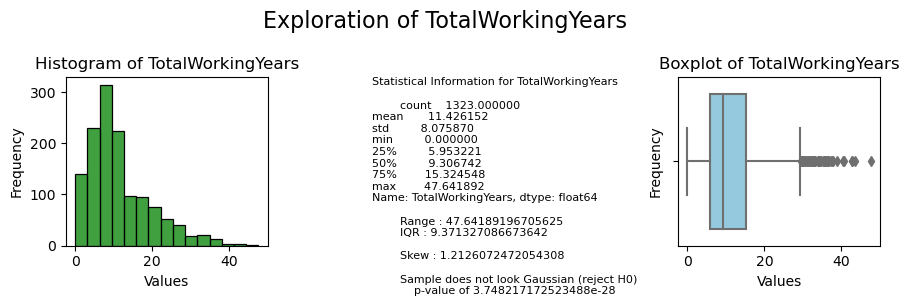

In [72]:
numerical_explore(df1, "TotalWorkingYears")

In [73]:
# Filter the DataFrame to get only rows where TotalWorkingYears is above 30
above_thirty_df = df[df['TotalWorkingYears'] > 30]

# rows
count_above_thirty = len(above_thirty_df)
count_above_thirty

49

In [74]:
# Filter the DataFrame to get only rows where TotalWorkingYears is above 30
above_thirty_df = df[df['TotalWorkingYears'] > 40]

# Count the number of rows in the filtered DataFrame
count_above_thirty = len(above_thirty_df)
count_above_thirty

6

In [75]:
df1.head()

,Age,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobSatisfaction
0,41.920786,8.063833,5.795945,3.993896,0.000000,4.594972,2.844897,3.397665
1,51.589037,8.965059,10.070232,7.937505,1.032295,5.901207,4.120281,1.584059
2,33.131540,8.427238,0.000000,0.000000,0.000000,0.000000,2.781168,3.301009
3,34.707073,7.662606,8.435324,5.563667,2.845429,0.000000,2.769576,3.220844
4,24.790188,6.241733,2.040124,1.970786,2.495949,2.219353,3.282183,1.697330


In [76]:
# before the features are binned the missing data in these columns will be dealt with

# why deal with it here first:
# while an imputation method could find different outputs the data is intended to be used as categorical data 
# to firstly bypass noise complications
# and secondly, the other features are more specific and harder to establish a baseline for


# two methods will be applied
# 1. TotalWorkingYears will be set to the maximum other year present
# 2. missing values of the other four year features will be set to unknown

# why not use an imputation technique
# in the trails run different imputation techniques did not help modelling

<Axes: >

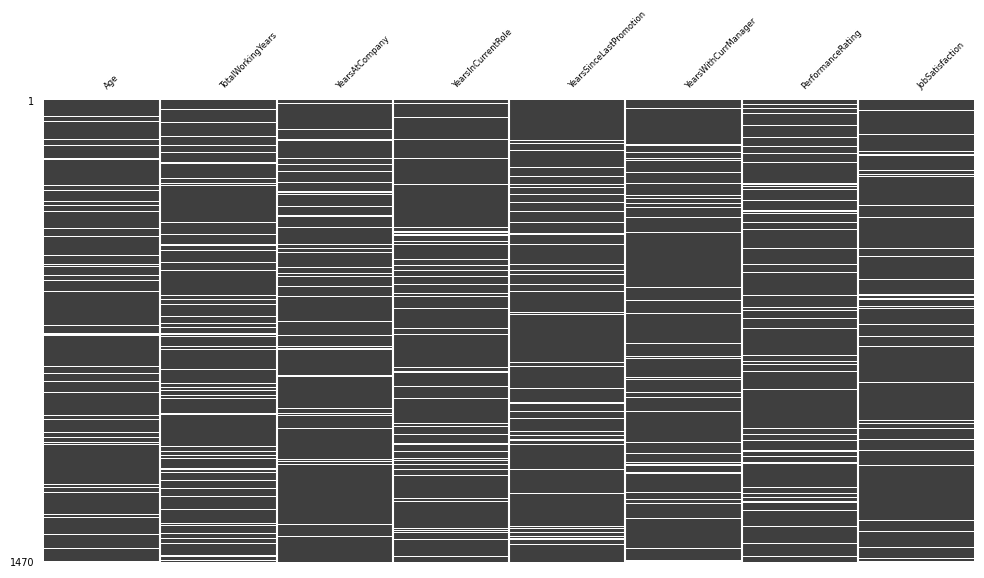

In [77]:
# there are no apparent white bands that would make logically filling in the data
msno.matrix(df1, sparkline=False, figsize=(12,6), fontsize=6)

In [78]:
# selecting year columns with a slice
_ = df1.iloc[:, 1:-2]
# several of the columns have more than 3 missing values but none are missing completely
_[_.isnull().sum(axis=1)>=3]

,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
47,8.582418,NaN,NaN,NaN,0.000000
165,23.143622,NaN,3.239644,NaN,NaN
186,22.384611,NaN,NaN,10.570969,NaN
427,NaN,17.768572,NaN,NaN,11.450390
435,NaN,7.583210,NaN,NaN,7.853904
454,NaN,NaN,2.009953,1.055888,NaN
459,NaN,NaN,NaN,NaN,8.082320
542,NaN,0.950828,NaN,NaN,0.000000
677,30.070683,NaN,NaN,1.136934,NaN
691,3.544187,NaN,NaN,NaN,NaN


In [79]:
year_features= ["YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"]

In [80]:
# if else lambda func
df['TotalWorkingYears'] = df.apply(lambda x: np.nanmax(x[year_features]) if pd.isna(x['TotalWorkingYears']) else x['TotalWorkingYears'], axis=1)
df.isnull().sum()

Age                         147
Attrition                   147
BusinessTravel              147
DailyRate                   147
Department                  147
DistanceFromHome            147
Education                   147
EducationField              147
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                      147
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                     147
JobSatisfaction             147
MaritalStatus               147
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
OverTime                    147
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears             0
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtCompany              147
YearsInC

In [81]:
def binning_years(df, year_features):

    for var in year_features:
        # include 75th percentile in bins
        per75 = df[var].quantile(0.75)
        # number of bins needed, rounded up
        bins = math.ceil(per75 / 5)
    
        # set bin edges
        bin_edges = [i * 5 for i in range(bins+1)] + [df[var].max()]
        #print(bin_edges)
    
        start = 0
        # Define labels for the bins
        bin_labels = [f'{start}-{start + 5}' for start in range(0, bins * 5, 5)] + [f'{bins * 5}+']
        #print(bin_labels)
        
        # Create a new column 'YearsAtCompanyBins' with bin labels
        df[var] = pd.cut(df[var], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
        # easier to fill with unknown in this function
        #df[var] = df[var].cat.add_categories(['Unknown'])
        df[var] = df[var].astype("object")
        
        df[var] = df[var].fillna('Unknown')
    return df

In [82]:
df = binning_years(df, year_features)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.9,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5-10,0-5,0-5,0-5
1,51.6,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10+,5-10,0-5,5-10
2,33.1,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0-5,0-5,0-5,0-5
3,34.7,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,5-10,5-10,0-5,0-5
4,24.8,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,0-5,0-5,0-5,0-5


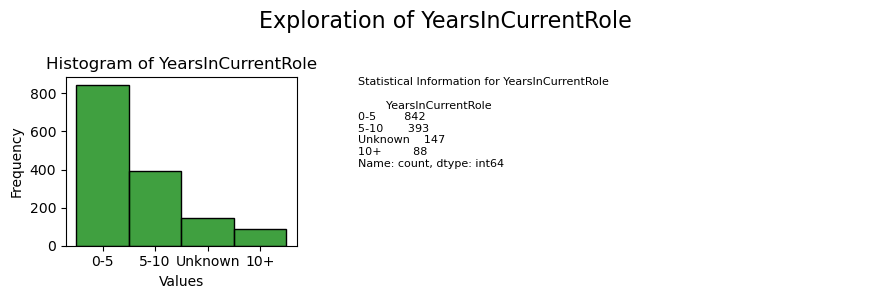

In [83]:
numerical_explore(df, "YearsInCurrentRole")

#### Ordinal features

In [84]:
# Some features appear to be ordinal
# these will be encoded as such
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1323.0,36.642706,9.866306,18.000000,29.600000,35.000000,42.750000,69.400000
DailyRate,1323.0,802.030050,414.031025,86.828045,456.479553,782.958705,1130.577949,1784.394456
DistanceFromHome,1323.0,9.091097,8.177870,0.750112,2.147069,6.920808,13.584900,33.684424
Education,1323.0,2.923447,1.072203,0.770362,2.122706,3.015658,3.700560,6.285161
EmployeeCount,1323.0,0.999325,0.099656,0.628985,0.931146,0.998949,1.067371,1.290613
EmployeeNumber,1323.0,1026.679166,610.480802,1.054148,501.854842,1022.025017,1533.811096,2530.919375
EnvironmentSatisfaction,1323.0,2.726443,1.129679,0.759655,1.894818,2.887313,3.676600,5.254672
HourlyRate,1323.0,65.647722,21.469709,23.855272,47.701897,64.934490,83.038355,123.200439
JobInvolvement,1323.0,2.743028,0.765568,0.722008,2.177638,2.859143,3.179128,5.241968
JobLevel,1323.0,2.058270,1.127018,0.715172,1.045228,1.936150,2.609707,5.942269


In [85]:
# columns to round
cols = ["Education", "EnvironmentSatisfaction", "JobInvolvement",
        "JobLevel", "RelationshipSatisfaction", "StockOptionLevel", "WorkLifeBalance"]

df[cols] = df[cols].round(0)#.astype(int) # doesn't work with na values

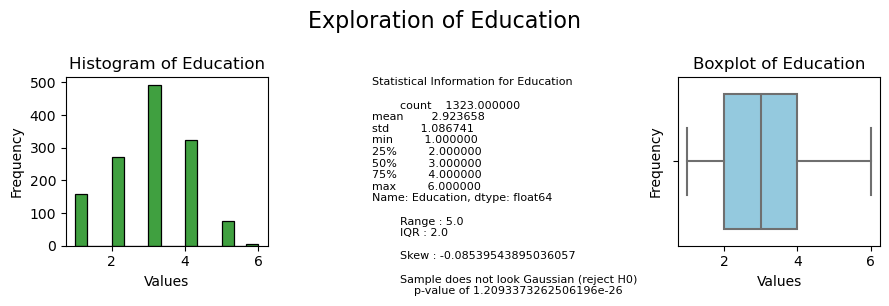

In [86]:
# each of the columns have outliers
# as the column will be made categorical they can be rouned down...
# ...effectively viewing the new top education rank as max
# this removes some intervals but removes fringe cases from analysis
numerical_explore(df, "Education")

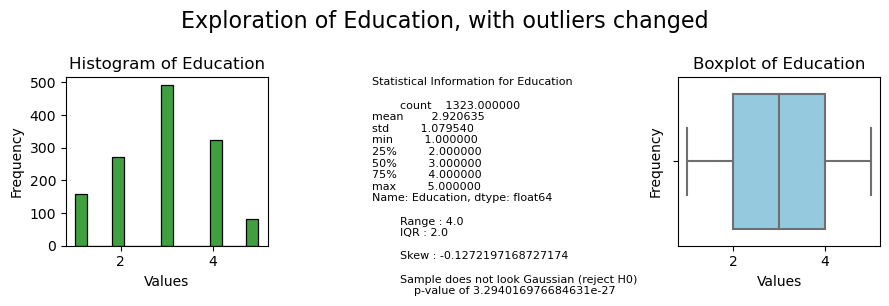

In [87]:
df['Education'] = df['Education'].replace(6.0, 5)
# each of the columns have outliers
numerical_explore(df, "Education", title="with outliers changed")

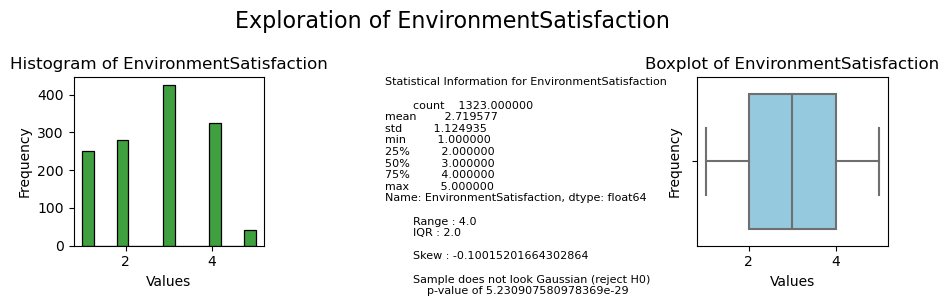

In [88]:
numerical_explore(df, "EnvironmentSatisfaction")

In [89]:
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace(5.0, 4)

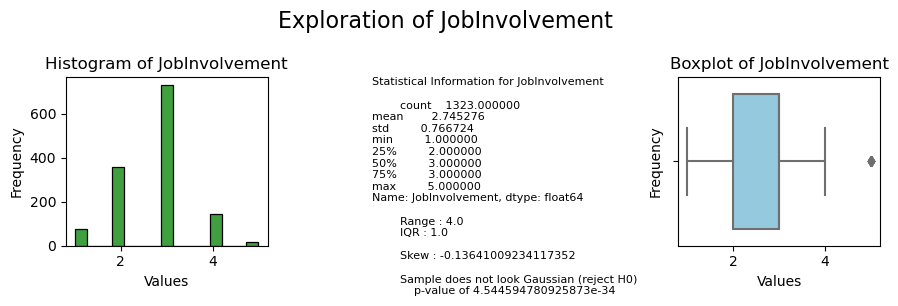

In [90]:
numerical_explore(df, "JobInvolvement")

In [91]:
df['JobInvolvement'] = df['JobInvolvement'].replace(5.0, 4)

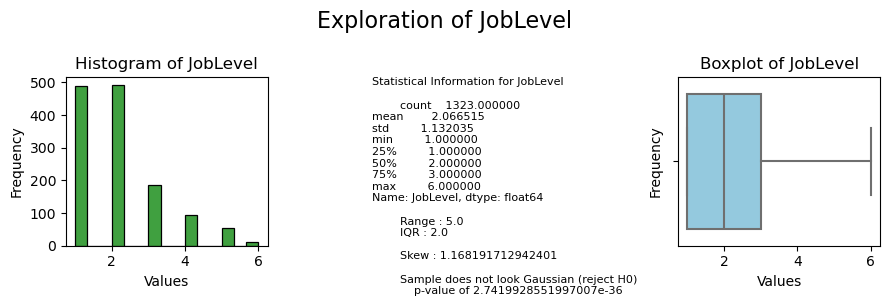

In [92]:
numerical_explore(df, "JobLevel")

In [93]:
df['JobLevel'] = df['JobLevel'].replace(6.0, 5)

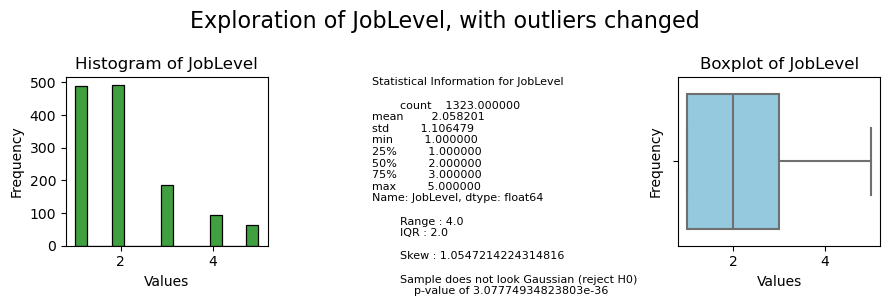

In [94]:
# job level is interesting
# the max job level could be merged with 4 and 5 as the new max,
# but maybe there is enough data points in them both to be useable
numerical_explore(df, "JobLevel", title="with outliers changed")

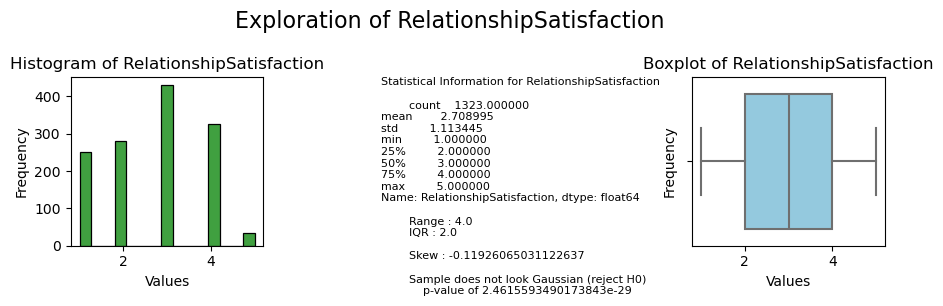

In [95]:
numerical_explore(df, "RelationshipSatisfaction")

In [96]:
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace(5.0, 4)

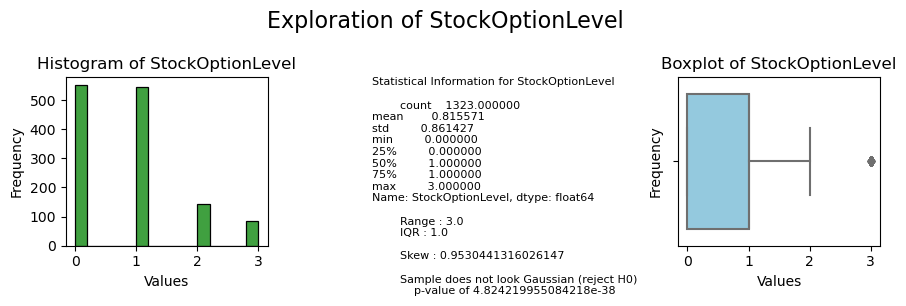

In [97]:
# stock option level is tricky
# as it is left with outliers but they are in a useable volume
# it might be one to look at if a higher level is related to any job types etc.
numerical_explore(df, "StockOptionLevel")

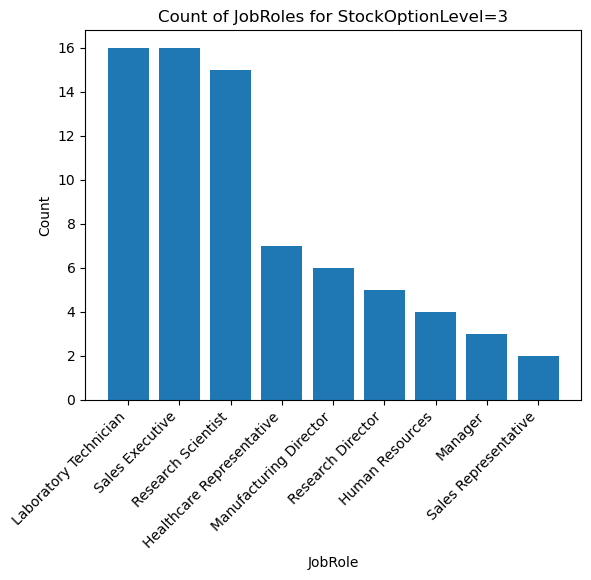

In [98]:
## change these graphs if time ##
# stock option level 3
result = df[df['StockOptionLevel'] == 3][['JobRole', 'StockOptionLevel']]
result = result["JobRole"].value_counts()
plt.bar(result.index, result.values)
plt.xlabel('JobRole')
plt.ylabel('Count')
plt.title('Count of JobRoles for StockOptionLevel=3')
plt.xticks(rotation=45, ha='right')
plt.show()

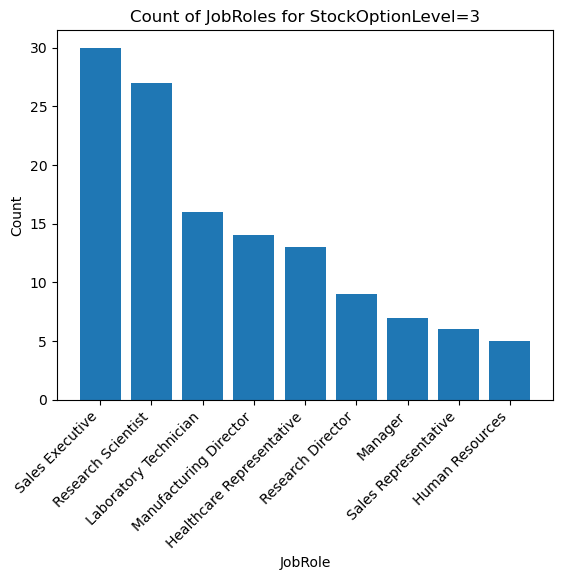

In [99]:
# stock option level 2
result = df[df['StockOptionLevel'] == 2][['JobRole', 'StockOptionLevel']]
result = result["JobRole"].value_counts()
plt.bar(result.index, result.values)
plt.xlabel('JobRole')
plt.ylabel('Count')
plt.title('Count of JobRoles for StockOptionLevel=3')
plt.xticks(rotation=45, ha='right') 
plt.show()

In [100]:
# it's hard to tell what stock level is related to
# could be related to job
# it's hard to tell unless their is noise/randomness in the categories
# will be kept in for modelling and maybe the relationship can be understood
df.JobRole.value_counts()

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64

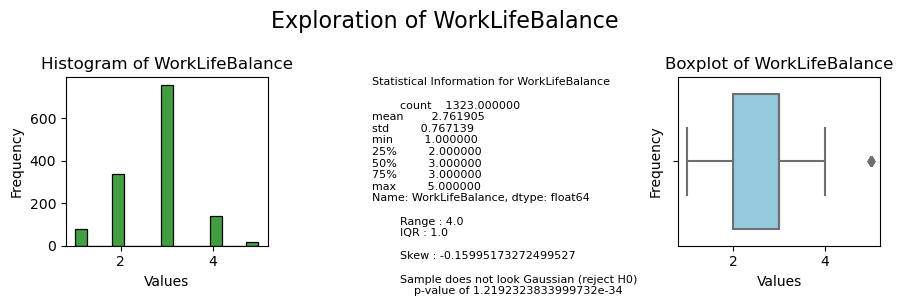

In [101]:
numerical_explore(df, "WorkLifeBalance")

In [102]:
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace(5.0, 4)

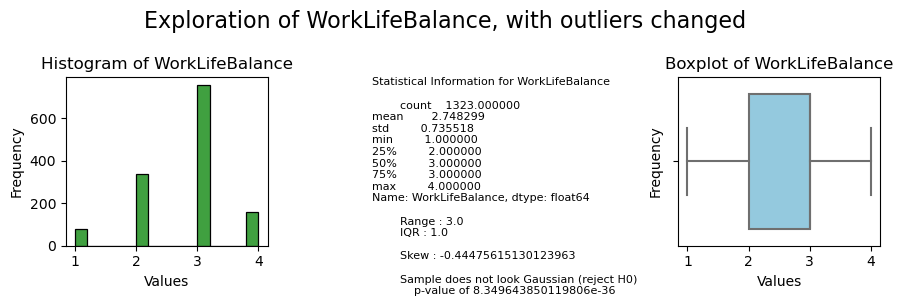

In [103]:
# maybe 1 has enough values to be usable
# a new min could be created too:
# if an employee scored 1-2 for WorkLifeBalance then set as 1 and change others accordingly.
numerical_explore(df, "WorkLifeBalance", title="with outliers changed")

In [104]:
### we have cleaned these features somewhat, but we have added some assumptions

### write down assumptions here ###


# cleaning these features hasn't restored them or attempted to pre disruption
# it has encoded them to allow for categorical analysis and handled small outliers 

#### Rounding Some Columns

In [105]:
# These will be rounded
# TotalWorkingYears wasn't rounded earlier
cols = ["NumCompaniesWorked", "TrainingTimesLastYear", "TotalWorkingYears", "DistanceFromHome"]

In [106]:
df[cols] = df[cols].round(0)

#### Filling Missing Data in Categories

In [107]:
cols = list(df.describe(include="object").columns)

In [108]:
# some have been filled already
df[cols].isnull().sum()

Attrition                  147
BusinessTravel             147
Department                 147
EducationField             147
Gender                     147
JobRole                    147
MaritalStatus              147
OverTime                   147
YearsAtCompany               0
YearsInCurrentRole           0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
dtype: int64

In [109]:
# looping through the categories
# they are unbalanced 
for i in cols:
    print(df[i].value_counts(), "\n") # end param can be used

Attrition
No     1065
Yes     258
Name: count, dtype: int64 

BusinessTravel
Travel_Rarely        890
Travel_Frequently    279
Non-Travel           154
Name: count, dtype: int64 

Department
Research & Development    824
Sales                     393
Human Resources           106
Name: count, dtype: int64 

EducationField
Life Sciences       504
Medical             397
Marketing           149
Technical Degree    141
Other                83
Human Resources      49
Name: count, dtype: int64 

Gender
Male      783
Female    540
Name: count, dtype: int64 

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64 

MaritalStatus
Married     596
Single      429
Divorced    298
Name: count, dtype: int64 

OverTime
No     92

In [110]:
# fill categories with unknown
df[cols] = df[cols].fillna("Unknown")
df.isnull().sum()

Age                         147
Attrition                     0
BusinessTravel                0
DailyRate                   147
Department                    0
DistanceFromHome            147
Education                   147
EducationField                0
EmployeeCount               147
EmployeeNumber              147
EnvironmentSatisfaction     147
Gender                        0
HourlyRate                  147
JobInvolvement              147
JobLevel                    147
JobRole                       0
JobSatisfaction             147
MaritalStatus                 0
MonthlyIncome               147
MonthlyRate                 147
NumCompaniesWorked          147
OverTime                      0
PercentSalaryHike           147
PerformanceRating           147
RelationshipSatisfaction    147
StandardHours               147
StockOptionLevel            147
TotalWorkingYears             0
TrainingTimesLastYear       147
WorkLifeBalance             147
YearsAtCompany                0
YearsInC

#### Money columns

In [111]:
# four columns are about monetary rates of the employees
# PercentSalaryHike is included here, and two decimal places will be kept as the level of percision
cols = ["DailyRate", "HourlyRate", "MonthlyIncome", "MonthlyRate", "PercentSalaryHike"]

In [112]:
# the question of precision is raised here.
# how precise do these figures need to be for modellin?


In [113]:

df[cols] = df[cols].round(2)

#### Remaining Columns

In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1323.0,36.642706,9.866306,18.000000,29.600000,35.000000,42.750000,69.400000
DailyRate,1323.0,802.029947,414.030836,86.830000,456.480000,782.960000,1130.580000,1784.390000
DistanceFromHome,1323.0,9.088435,8.173175,1.000000,2.000000,7.000000,14.000000,34.000000
Education,1323.0,2.920635,1.079540,1.000000,2.000000,3.000000,4.000000,5.000000
EmployeeCount,1323.0,0.999325,0.099656,0.628985,0.931146,0.998949,1.067371,1.290613
EmployeeNumber,1323.0,1026.679166,610.480802,1.054148,501.854842,1022.025017,1533.811096,2530.919375
EnvironmentSatisfaction,1323.0,2.687831,1.073006,1.000000,2.000000,3.000000,4.000000,4.000000
HourlyRate,1323.0,65.647695,21.469735,23.860000,47.705000,64.930000,83.035000,123.200000
JobInvolvement,1323.0,2.733938,0.740214,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1323.0,2.058201,1.106479,1.000000,1.000000,2.000000,3.000000,5.000000


#### 'Target' Variables

In [115]:
# testing rounding them for regression
# these were statistical targets identified and were modelled with regression but with poor results
cols = ["JobSatisfaction", "PerformanceRating"]

In [116]:
df[cols] = df[cols].round(2)

#### Attrition

In [117]:
df.Attrition.value_counts()

Attrition
No         1065
Yes         258
Unknown     147
Name: count, dtype: int64

In [118]:
df.Age

0       41.9
1       51.6
2       33.1
3       34.7
4       24.8
        ... 
1465    37.4
1466    35.0
1467    26.9
1468     NaN
1469    38.1
Name: Age, Length: 1470, dtype: float64

#### Employee Count

In [119]:
# 'likely a constant' according to the data dictionary,
#  there are no other features that are a constant value that could have been misslabelled
# is from a normal distribution
# shows no correlation with any other numeric feature

In [120]:
df.EmployeeCount.describe()

count    1323.000000
mean        0.999325
std         0.099656
min         0.628985
25%         0.931146
50%         0.998949
75%         1.067371
max         1.290613
Name: EmployeeCount, dtype: float64

#### Employee Number

In [121]:
# unique number for each employee according to data disct
df.EmployeeNumber.nunique()

1323

In [122]:
df.EmployeeNumber.describe()

count    1323.000000
mean     1026.679166
std       610.480802
min         1.054148
25%       501.854842
50%      1022.025017
75%      1533.811096
max      2530.919375
Name: EmployeeNumber, dtype: float64

In [123]:
# when rounded there are less unique numbers
# noise add
df1.EmployeeNumber = df.EmployeeNumber.round(0)
df1.EmployeeNumber.nunique()

992

#### Drop non-information columns

In [124]:
df = df.drop(["StandardHours", "EmployeeNumber"], axis=1)

In [125]:
# missing value in categories is dealt with
df.select_dtypes(include='object').isnull().sum()

Attrition                  0
BusinessTravel             0
Department                 0
EducationField             0
Gender                     0
JobRole                    0
MaritalStatus              0
OverTime                   0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64

In [126]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.9,Yes,Travel_Rarely,990.11,Sales,1.0,2.0,Life Sciences,1.033298,2.0,...,2.84,1.0,0.0,8.0,0.0,1.0,5-10,0-5,0-5,0-5
1,51.6,No,Travel_Frequently,276.78,Research & Development,NaN,1.0,Life Sciences,0.944859,3.0,...,4.12,4.0,1.0,9.0,3.0,3.0,10+,5-10,0-5,5-10
2,33.1,Yes,Travel_Rarely,1204.16,Research & Development,2.0,2.0,Other,0.810809,4.0,...,2.78,2.0,0.0,8.0,3.0,3.0,0-5,0-5,0-5,0-5
3,34.7,No,Travel_Frequently,1352.75,Sales,3.0,4.0,Life Sciences,0.822976,4.0,...,2.77,3.0,0.0,8.0,3.0,3.0,5-10,5-10,0-5,0-5
4,24.8,No,Travel_Rarely,485.05,Research & Development,2.0,1.0,Medical,NaN,1.0,...,3.28,NaN,1.0,6.0,3.0,3.0,0-5,0-5,0-5,0-5


### 3.3. Apply encoding, scaling and feature engineering as and if required, detailing how and why you used these techniques and the rationale for your decisions.

In [127]:
# some encoding and feature engineering has been performed above
# may add more feature engineering

In [128]:
df_prepared = df.copy()

In [129]:
# setting X and y
target = "Attrition"
df_prepared = df_prepared[df_prepared[target] != "Unknown"] # dropping unknowns in target
y = df_prepared["Attrition"]
y = y.reset_index(drop=True) # reseting index for later
X = df_prepared.drop([target], axis=1)

In [130]:
label_encode = LabelEncoder()
y = label_encode.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0])

In [131]:
# col type
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include='number').columns

# Use RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', IterativeImputer()), ('scaler', StandardScaler())]), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('pca', PCA(0.995)),
    #('lda', LDA()),
    ('classifier', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


# Fit the pipeline on the resampled data
pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7211538461538461
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76        59
           1       0.68      0.67      0.67        45

    accuracy                           0.72       104
   macro avg       0.72      0.71      0.72       104
weighted avg       0.72      0.72      0.72       104



In [132]:
# mean imputation
X[X.select_dtypes(include='number').columns] = X.select_dtypes(include='number').fillna(X.select_dtypes(include='number').mean())
X.tail()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1465,37.400000,Travel_Frequently,914.06,Research & Development,22.000000,2.938655,Medical,0.950166,3.0,Male,...,2.970000,3.0,1.0,5.0,3.0,3.0,5-10,0-5,0-5,Unknown
1466,35.000000,Unknown,574.68,Research & Development,6.000000,1.000000,Medical,1.064563,4.0,Male,...,2.800000,1.0,1.0,8.0,5.0,3.0,5-10,5-10,0-5,5-10
1467,26.900000,Travel_Rarely,151.51,Research & Development,9.028547,3.000000,Life Sciences,0.960908,2.0,Male,...,3.149462,2.0,1.0,6.0,0.0,3.0,5-10,0-5,0-5,0-5
1468,36.632407,Travel_Frequently,995.98,Human Resources,2.000000,3.000000,Medical,0.873312,4.0,Male,...,3.220000,4.0,0.0,15.0,3.0,2.0,5-10,5-10,0-5,Unknown
1469,38.100000,Travel_Rarely,703.68,Research & Development,7.000000,3.000000,Medical,1.061133,2.0,Male,...,3.050000,1.0,0.0,6.0,3.0,4.0,0-5,0-5,0-5,0-5


In [133]:
# standard scaling
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X.select_dtypes(include='number'))
scaled_df = pd.DataFrame(data=scaled_df, columns=X.select_dtypes(include='number').columns)
scaled_df.tail()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance
1318,8.315996e-02,0.284481,1.677303,-4.344243e-16,-0.513423,0.321919,0.000000,0.379819,-0.052503,1.340310,-8.271865e-01,-1.838315e-01,0.567320,0.689670,-3.970972e-01,0.332342,0.209064,-0.748758,0.149596,0.350390
1319,-1.768529e-01,-0.581235,-0.391613,-1.896464e+00,0.694283,1.299994,-1.276349,-1.040633,0.894141,0.000000,-4.012236e-16,9.607122e-01,0.000000,-0.164171,-7.732583e-01,-1.630293,0.209064,-0.372435,1.745284,0.350390
1320,-1.054396e+00,-1.660688,0.000000,6.000947e-02,-0.400013,-0.656156,1.275704,1.800272,-0.052503,-0.535151,1.163591e-02,-2.619078e-16,-0.685205,0.906434,-9.826417e-16,-0.648976,0.209064,-0.623317,-2.243936,0.350390
1321,7.697926e-16,0.493448,-0.908842,6.000947e-02,-1.324775,1.299994,-0.326232,-1.040633,-0.052503,0.000000,-2.143520e-01,-3.622625e-01,-0.267697,-0.629421,1.560809e-01,1.313659,-1.007587,0.505651,0.149596,-1.087294
1322,1.589970e-01,-0.252172,-0.262306,6.000947e-02,0.658070,-0.656156,0.075608,1.800272,-0.052503,0.142615,-3.017923e-01,-5.871488e-01,-0.267697,-1.314080,-2.200802e-01,-1.630293,-1.007587,-0.623317,0.149596,1.788075


In [134]:
# encoding
encoded_df = pd.get_dummies(X.select_dtypes(include='object'))
encoded_df = encoded_df.reset_index(drop=True)
encoded_df.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,BusinessTravel_Unknown,Department_Human Resources,Department_Research & Development,Department_Sales,Department_Unknown,EducationField_Human Resources,EducationField_Life Sciences,...,YearsInCurrentRole_10+,YearsInCurrentRole_5-10,YearsInCurrentRole_Unknown,YearsSinceLastPromotion_0-5,YearsSinceLastPromotion_5+,YearsSinceLastPromotion_Unknown,YearsWithCurrManager_0-5,YearsWithCurrManager_10+,YearsWithCurrManager_5-10,YearsWithCurrManager_Unknown
0,False,False,True,False,False,False,True,False,False,True,...,False,False,False,True,False,False,True,False,False,False
1,False,True,False,False,False,True,False,False,False,True,...,False,True,False,True,False,False,False,False,True,False
2,False,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False
3,False,True,False,False,False,False,True,False,False,True,...,False,True,False,True,False,False,True,False,False,False
4,False,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,False,True,False,False,False


In [135]:
# merge dataframes
X_processed = pd.concat([scaled_df, encoded_df], axis=1)

In [136]:
X_processed.shape

(1323, 70)

In [137]:
sampler = RandomUnderSampler(random_state=42)

X_sampled, y_sampled = sampler.fit_resample(X_processed, y)


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

In [138]:
# model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# clasification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Logistic Regression Accuracy: 0.6442307692307693
Confusion Matrix:
[[40 19]
 [18 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68        59
           1       0.59      0.60      0.59        45

    accuracy                           0.64       104
   macro avg       0.64      0.64      0.64       104
weighted avg       0.65      0.64      0.64       104



### 3.4. Explore the possibility of using dimensional reduction on the dataset. Employ both LDA (Linear Discriminant Analysis) and PCA (Principal Component Analysis) and compare the separation of classes through visualization. Explain the difference between both techniques in your own words and discuss in detail how your results may affect your analysis of classifying or clustering the normal as compared to anomalous biddings.

In [139]:
X_processed.head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,YearsInCurrentRole_10+,YearsInCurrentRole_5-10,YearsInCurrentRole_Unknown,YearsSinceLastPromotion_0-5,YearsSinceLastPromotion_5+,YearsSinceLastPromotion_Unknown,YearsWithCurrManager_0-5,YearsWithCurrManager_10+,YearsWithCurrManager_5-10,YearsWithCurrManager_Unknown
0,0.570684,0.478475,-1.038150,-0.918227,3.642077e-01,-0.656156,1.385655,0.379819,-0.052503,0.625407,...,False,False,False,True,False,False,True,False,False,False
1,1.621569,-1.341140,0.000000,-1.896464,-5.694449e-01,0.321919,-0.662003,-1.040633,-0.052503,-1.064365,...,False,True,False,True,False,False,False,False,True,False
2,-0.382696,1.024489,-0.908842,-0.918227,-1.984617e+00,1.299994,1.062211,-1.040633,-0.999147,0.532562,...,False,False,False,True,False,False,True,False,False,False
3,-0.209354,1.403524,-0.779535,1.038246,-1.856178e+00,1.299994,-0.460836,0.379819,-0.999147,0.458286,...,False,True,False,True,False,False,True,False,False,False
4,-1.281907,-0.809870,-0.908842,-1.896464,2.344141e-15,-1.634231,-1.247259,0.379819,-0.999147,-0.952952,...,False,False,False,True,False,False,True,False,False,False


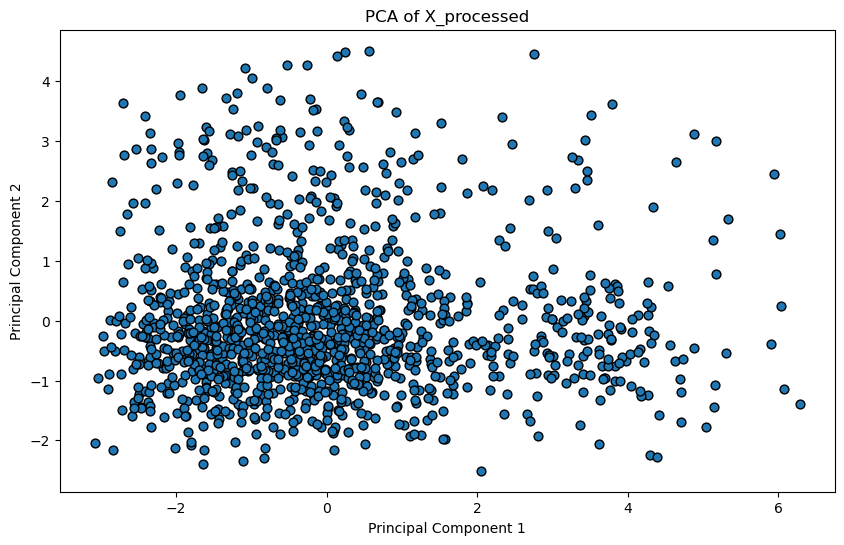

In [140]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Specify the number of components you want
X_pca = pca.fit_transform(X_processed)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis', edgecolor='k', s=40)
plt.title('PCA of X_processed')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [141]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Apply PCA to reduce dimensionality
pca = PCA(0.995)  # Specify the number of components you want
X_pca = pca.fit_transform(X_processed)

X_pca.shape

(1323, 55)

In [142]:
sampler = RandomUnderSampler(random_state=42)

X_pca_sampled, y_pca_sampled = sampler.fit_resample(X_pca, y)


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_pca_sampled, y_pca_sampled, test_size=0.2, random_state=42)

In [143]:
# model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# clasification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Logistic Regression Accuracy: 0.6346153846153846
Confusion Matrix:
[[40 19]
 [19 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68        59
           1       0.58      0.58      0.58        45

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.63      0.63      0.63       104



In [144]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA to reduce dimensionality
lda = LinearDiscriminantAnalysis() 
X_lda = lda.fit_transform(X_processed, y) 

X_lda.shape

(1323, 1)

In [145]:
sampler = RandomUnderSampler(random_state=42)

X_lda_sampled, y_lda_sampled = sampler.fit_resample(X_lda, y)


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda_sampled, y_lda_sampled, test_size=0.2, random_state=42)

In [146]:
# model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# clasification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Logistic Regression Accuracy: 0.7115384615384616
Confusion Matrix:
[[45 14]
 [16 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        59
           1       0.67      0.64      0.66        45

    accuracy                           0.71       104
   macro avg       0.71      0.70      0.70       104
weighted avg       0.71      0.71      0.71       104



#### Mixed

In [147]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA to reduce dimensionality
lda = LinearDiscriminantAnalysis() 
X_lda_m = lda.fit_transform(scaled_df, y) 

X_lda_m.shape

(1323, 1)

In [148]:
# Apply PCA to reduce dimensionality
pca = PCA(0.995)  # Specify the number of components you want
X_pca_m = pca.fit_transform(encoded_df)

X_pca_m.shape

(1323, 38)

In [149]:
merged_array = np.hstack((X_lda_m, X_pca_m))
merged_array.shape

(1323, 39)

In [150]:
sampler = RandomUnderSampler(random_state=42)

X_mixed_sampled, y_mixed_sampled = sampler.fit_resample(merged_array, y)


# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_mixed_sampled, y_mixed_sampled, test_size=0.2, random_state=42)

In [151]:
# model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# clasification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)

Logistic Regression Accuracy: 0.6346153846153846
Confusion Matrix:
[[39 20]
 [18 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67        59
           1       0.57      0.60      0.59        45

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.64      0.63      0.64       104



## 4. Module: Statistical Analysis

### 4.1. Use descriptive statistical analyses to explore and evaluate the data set, including measures of central tendency and dispersion and frequency distributions. Correlation matrices are also accepted. Provide a summary of your findings.

In [152]:
### examine the ranges of the data here... or data prep.. or both...

In [153]:
# original dataframe
df = df_orgnl.copy()

In [154]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


In [155]:
# make it a variable
df_descriptive = df.describe().T

# add mode
df_descriptive['mode'] = df.mode().iloc[0]

df_descriptive

,count,mean,std,min,25%,50%,75%,max,mode
Age,1323.0,36.635268,9.882161,14.544608,29.624982,34.951950,42.748741,69.402515,14.544608
DailyRate,1323.0,802.030050,414.031025,86.828045,456.479553,782.958705,1130.577949,1784.394456,86.828045
DistanceFromHome,1323.0,9.091097,8.177870,0.750112,2.147069,6.920808,13.584900,33.684424,0.750112
Education,1323.0,2.923447,1.072203,0.770362,2.122706,3.015658,3.700560,6.285161,0.770362
EmployeeCount,1323.0,0.999325,0.099656,0.628985,0.931146,0.998949,1.067371,1.290613,0.628985
EmployeeNumber,1323.0,1026.679166,610.480802,1.054148,501.854842,1022.025017,1533.811096,2530.919375,1.054148
EnvironmentSatisfaction,1323.0,2.726443,1.129679,0.759655,1.894818,2.887313,3.676600,5.254672,0.759655
HourlyRate,1323.0,65.647722,21.469709,23.855272,47.701897,64.934490,83.038355,123.200439,23.855272
JobInvolvement,1323.0,2.743028,0.765568,0.722008,2.177638,2.859143,3.179128,5.241968,0.722008
JobLevel,1323.0,2.058270,1.127018,0.715172,1.045228,1.936150,2.609707,5.942269,0.715172


In [156]:
df.describe(include='object').T

,count,unique,top,freq
Attrition,1323,2,No,1065
BusinessTravel,1323,3,Travel_Rarely,890
Department,1323,3,Research & Development,824
EducationField,1323,6,Life Sciences,504
Gender,1323,2,Male,783
JobRole,1323,9,Sales Executive,281
MaritalStatus,1323,3,Married,596
Over18,1323,1,Y,1323
OverTime,1323,2,No,929


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1323 non-null   float64
 1   Attrition                 1323 non-null   object 
 2   BusinessTravel            1323 non-null   object 
 3   DailyRate                 1323 non-null   float64
 4   Department                1323 non-null   object 
 5   DistanceFromHome          1323 non-null   float64
 6   Education                 1323 non-null   float64
 7   EducationField            1323 non-null   object 
 8   EmployeeCount             1323 non-null   float64
 9   EmployeeNumber            1323 non-null   float64
 10  EnvironmentSatisfaction   1323 non-null   float64
 11  Gender                    1323 non-null   object 
 12  HourlyRate                1323 non-null   float64
 13  JobInvolvement            1323 non-null   float64
 14  JobLevel

In [158]:
# variance
numeric_df = df.select_dtypes(include=['number'])
var_df = numeric_df.var()
var_df

Age                         9.765712e+01
DailyRate                   1.714217e+05
DistanceFromHome            6.687755e+01
Education                   1.149620e+00
EmployeeCount               9.931409e-03
EmployeeNumber              3.726868e+05
EnvironmentSatisfaction     1.276176e+00
HourlyRate                  4.609484e+02
JobInvolvement              5.860946e-01
JobLevel                    1.270170e+00
JobSatisfaction             1.315119e+00
MonthlyIncome               2.272029e+07
MonthlyRate                 5.284448e+07
NumCompaniesWorked          6.294838e+00
PercentSalaryHike           1.596564e+01
PerformanceRating           2.266016e-01
RelationshipSatisfaction    1.245365e+00
StandardHours               6.436107e+01
StockOptionLevel            7.448999e-01
TotalWorkingYears           6.521967e+01
TrainingTimesLastYear       1.766357e+00
WorkLifeBalance             5.803427e-01
YearsAtCompany              3.656377e+01
YearsInCurrentRole          1.338178e+01
YearsSinceLastPr

In [159]:
# ranges
ranges = df.select_dtypes(include=['number']).max() - df.select_dtypes(include=['number']).min()
ranges

Age                            54.857907
DailyRate                    1697.566411
DistanceFromHome               32.934312
Education                       5.514800
EmployeeCount                   0.661628
EmployeeNumber               2529.865227
EnvironmentSatisfaction         4.495018
HourlyRate                     99.345167
JobInvolvement                  4.519960
JobLevel                        5.227097
JobSatisfaction                 4.527085
MonthlyIncome               21966.539381
MonthlyRate                 31184.213419
NumCompaniesWorked             10.855733
PercentSalaryHike              22.112538
PerformanceRating               2.896420
RelationshipSatisfaction        4.371584
StandardHours                  53.585646
StockOptionLevel                3.474319
TotalWorkingYears              47.641892
TrainingTimesLastYear           7.503201
WorkLifeBalance                 4.056948
YearsAtCompany                 36.848408
YearsInCurrentRole             19.091844
YearsSinceLastPr

In [160]:
# Inner Quartile Range
iqr = df.select_dtypes(include=['number']).quantile(0.75) - df.select_dtypes(include=['number']).quantile(0.25)
iqr

Age                            13.123759
DailyRate                     674.098396
DistanceFromHome               11.437831
Education                       1.577854
EmployeeCount                   0.136225
EmployeeNumber               1031.956255
EnvironmentSatisfaction         1.781782
HourlyRate                     35.336459
JobInvolvement                  1.001490
JobLevel                        1.564478
JobSatisfaction                 1.830624
MonthlyIncome                5306.158431
MonthlyRate                 12183.703191
NumCompaniesWorked              3.010867
PercentSalaryHike               5.550539
PerformanceRating               0.490023
RelationshipSatisfaction        1.730951
StandardHours                  10.781223
StockOptionLevel                1.082523
TotalWorkingYears               9.371327
TrainingTimesLastYear           1.399621
WorkLifeBalance                 1.012727
YearsAtCompany                  6.564736
YearsInCurrentRole              5.228199
YearsSinceLastPr

In [161]:
# Measures of variability
summary_table = pd.DataFrame({
    'Variance': var_df,
    'Range': ranges,
    'Inner Quartile Range': iqr
})

print(summary_table)

                              Variance         Range  Inner Quartile Range
Age                       9.765712e+01     54.857907             13.123759
DailyRate                 1.714217e+05   1697.566411            674.098396
DistanceFromHome          6.687755e+01     32.934312             11.437831
Education                 1.149620e+00      5.514800              1.577854
EmployeeCount             9.931409e-03      0.661628              0.136225
EmployeeNumber            3.726868e+05   2529.865227           1031.956255
EnvironmentSatisfaction   1.276176e+00      4.495018              1.781782
HourlyRate                4.609484e+02     99.345167             35.336459
JobInvolvement            5.860946e-01      4.519960              1.001490
JobLevel                  1.270170e+00      5.227097              1.564478
JobSatisfaction           1.315119e+00      4.527085              1.830624
MonthlyIncome             2.272029e+07  21966.539381           5306.158431
MonthlyRate              

In [162]:
correlation_matrix = df.select_dtypes(include=['number'])
correlation_matrix.corr().shape

(26, 26)

In [163]:
correlation_matrix.corr()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.003115,-0.004483,0.218413,-0.012545,-0.003796,-0.011972,0.027241,0.023650,0.467031,...,0.025094,0.002155,0.042739,0.625620,-0.021116,-0.035865,0.273534,0.179098,0.183958,0.183590
DailyRate,0.003115,1.000000,-0.004227,-0.012328,0.009567,-0.050564,0.019894,0.031691,0.051141,-0.013380,...,0.019652,-0.040108,0.007044,0.013766,-0.009000,-0.035260,-0.038210,0.007122,-0.022840,-0.039930
DistanceFromHome,-0.004483,-0.004227,1.000000,0.012109,0.005865,0.035067,-0.030355,0.026033,-0.005980,0.023336,...,0.024771,-0.002562,0.039794,0.004308,-0.047087,-0.017814,0.023940,0.020311,-0.005743,0.033454
Education,0.218413,-0.012328,0.012109,1.000000,-0.037297,0.035267,0.007502,0.003187,0.033630,0.106218,...,-0.019207,0.010267,0.008528,0.147655,-0.034722,-0.004356,0.075283,0.072572,0.050648,0.065608
EmployeeCount,-0.012545,0.009567,0.005865,-0.037297,1.000000,0.063013,0.026024,0.056652,-0.039578,0.004059,...,0.015579,-0.003399,-0.038158,0.002776,-0.054455,-0.004015,0.018562,0.016204,-0.004410,-0.033018
EmployeeNumber,-0.003796,-0.050564,0.035067,0.035267,0.063013,1.000000,0.040412,0.003557,-0.016547,-0.004218,...,-0.072664,0.000358,0.063318,-0.019994,-0.006759,0.020873,-0.002520,-0.017335,-0.008418,-0.020842
EnvironmentSatisfaction,-0.011972,0.019894,-0.030355,0.007502,0.026024,0.040412,1.000000,-0.037906,-0.022821,0.007245,...,0.025902,-0.018980,-0.001693,-0.012346,-0.029385,0.037832,-0.021525,-0.001210,-0.000513,-0.051181
HourlyRate,0.027241,0.031691,0.026033,0.003187,0.056652,0.003557,-0.037906,1.000000,0.031025,-0.010295,...,0.003273,-0.017825,0.031599,0.047688,-0.030968,-0.016889,0.037367,-0.005881,0.008520,0.014796
JobInvolvement,0.023650,0.051141,-0.005980,0.033630,-0.039578,-0.016547,-0.022821,0.031025,1.000000,-0.008527,...,0.003356,0.003931,0.008476,0.012578,-0.033358,-0.023270,0.000706,0.032181,0.022490,0.046256
JobLevel,0.467031,-0.013380,0.023336,0.106218,0.004059,-0.004218,0.007245,-0.010295,-0.008527,1.000000,...,0.023036,0.043070,0.017891,0.756814,-0.038575,0.041841,0.494295,0.365519,0.349137,0.357980


correlation shape: (26, 26)


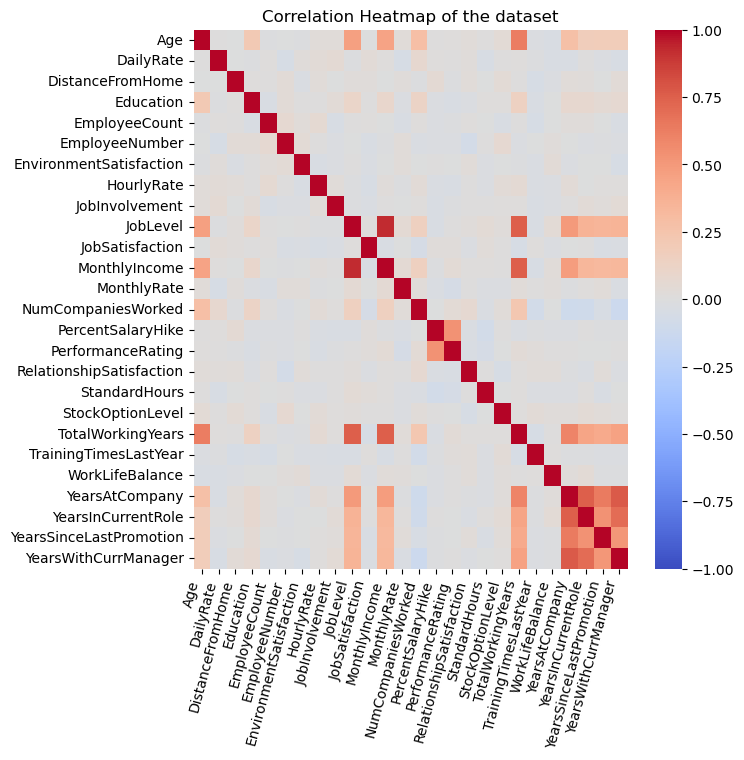

In [164]:
### this correlation section is repeated from data prep ###

# correlation is easier to view in a larger number of features like this
# correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()
print(f"correlation shape: {correlation_matrix.shape}")

# correlation heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=75, ha='right')
plt.title('Correlation Heatmap of the dataset')
plt.show()

In [165]:
# from above, monthly income and job level are highly correlated
df.MonthlyIncome.corr(df.JobLevel)

0.9235098140677838

In [166]:
# total working years is correlated with some features too
print("Correlations of TotalWorkingYears")
print("vs. JobLevel: ", df.TotalWorkingYears.corr(df.JobLevel))
print("vs. MonthlyIncome: ", df.TotalWorkingYears.corr(df.MonthlyIncome))
print("vs. YearsAtCompany: ", df.TotalWorkingYears.corr(df.YearsAtCompany))

Correlations of TotalWorkingYears
vs. JobLevel:  0.7568136270833515
vs. MonthlyIncome:  0.757637022403104
vs. YearsAtCompany:  0.593883740319838


In [167]:
# the last 4 columns are correlated together
# they are all related to years working
df.iloc[:,-4:].corr()

,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
YearsAtCompany,1.000000,0.753423,0.639672,0.767222
YearsInCurrentRole,0.753423,1.000000,0.532027,0.702790
YearsSinceLastPromotion,0.639672,0.532027,1.000000,0.509521
YearsWithCurrManager,0.767222,0.702790,0.509521,1.000000


### 4.2. Formulate and test hypotheses within a business context using appropriate statistical techniques like t-tests or ANOVA to identify significant relationships between variables. Provide a summary of your findings. Use at least two statistical tests. 

#### Target variables

In [168]:
# The company wishes to know what features influence these features

In [169]:
# business objectives are represented by features in the data
df[["JobSatisfaction", "PerformanceRating"]].describe()

,JobSatisfaction,PerformanceRating
count,1323.000000,1323.000000
mean,2.715272,3.149344
std,1.146786,0.476027
min,0.724192,2.116951
25%,1.846039,2.845502
50%,2.895032,3.064551
75%,3.676663,3.335525
max,5.251277,5.013371


In [170]:
df[["JobSatisfaction", "PerformanceRating"]].head()

,JobSatisfaction,PerformanceRating
0,3.397665,2.844897
1,1.584059,4.120281
2,3.301009,2.781168
3,3.220844,2.769576
4,1.697330,3.282183


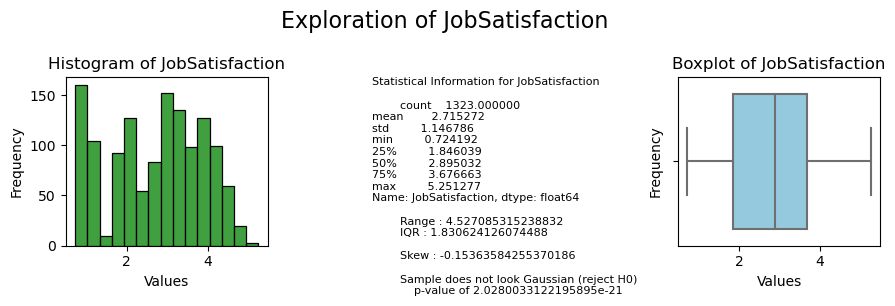

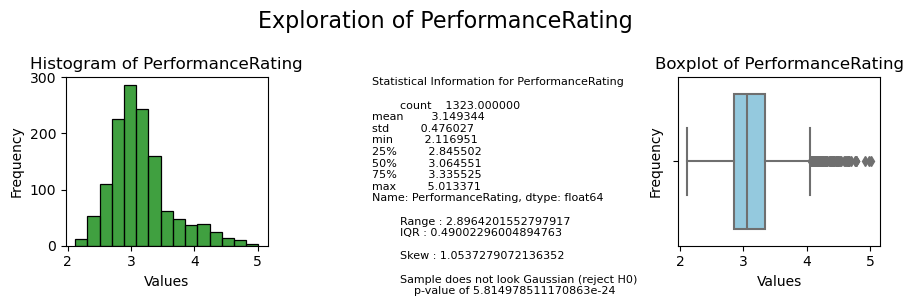

In [171]:
for i in ["JobSatisfaction", "PerformanceRating"]:
    numerical_explore(df, i)

In [172]:
X1 = df["JobSatisfaction"]
X2 = df["PerformanceRating"]

In [173]:
# We can perform the test using those variables
# we show with the two sample t test that the features are independent from each other and require more investigation and predicition of both
# at 5% significance level we reject the hypothesis that these features are the same
X1 = X1.dropna()
X2 = X2.dropna()



t_test = stats.ttest_ind(X1, X2, equal_var = False)
display(t_test)

TtestResult(statistic=-12.715653733987903, pvalue=1.66177889187303e-35, df=1764.4389750891976)

In [174]:
# there is also low correlation between them (which is to be expected)
# but it means that both are to be investigated
X1.corr(X2)

0.02039224505497148

#### Chi Squared Tests

In [175]:
# some categories are examined with chi2 test
# this examines the expected frequency of the categories if they were based on chance and no relationship between them


In [176]:
df.describe(include="object")

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1323,1323,1323,1323,1323,1323,1323,1323,1323
unique,2,3,3,6,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,Y,No
freq,1065,890,824,504,783,281,596,1323,929


In [177]:
def chi_square(df, y, x="Attrition"):

    print(f"Chi squared test for {x} and {y}\n")
    
    contingency_table = pd.crosstab(df[x], df[y])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(contingency_table, "\n")

    print("Chi-squared statistic:", chi2)
    print("p-value:", p)
    print("Degrees of freedom:", dof, "\n")
    print("Expected frequencies:", expected)


In [178]:
# there is no relationship proven here
chi_square(df, "BusinessTravel")

Chi squared test for Attrition and BusinessTravel

BusinessTravel  Non-Travel  Travel_Frequently  Travel_Rarely
Attrition                                                   
No                     115                184            655
Yes                     19                 69            146 

Chi-squared statistic: 12.853284660340115
p-value: 0.0016178740115298253
Degrees of freedom: 2 

Expected frequencies: [[107.60606061 203.16666667 643.22727273]
 [ 26.39393939  49.83333333 157.77272727]]


In [179]:
chi_square(df, "Department")

Chi squared test for Attrition and Department

Department  Human Resources  Research & Development  Sales
Attrition                                                 
No                       73                     615    278
Yes                      21                     123     77 

Chi-squared statistic: 4.925509578372196
p-value: 0.08519991956789548
Degrees of freedom: 2 

Expected frequencies: [[ 76.49873631 600.59646167 288.90480202]
 [ 17.50126369 137.40353833  66.09519798]]


In [180]:
chi_square(df, "MaritalStatus")

Chi squared test for Attrition and MaritalStatus

MaritalStatus  Divorced  Married  Single
Attrition                               
No                  224      448     286
Yes                  41       88     107 

Chi-squared statistic: 20.663088139334302
p-value: 3.2588728866429146e-05
Degrees of freedom: 2 

Expected frequencies: [[212.62144054 430.05695142 315.32160804]
 [ 52.37855946 105.94304858  77.67839196]]


In [181]:
chi_square(df, "OverTime")

Chi squared test for Attrition and OverTime

OverTime    No  Yes
Attrition          
No         715  241
Yes        127  109 

Chi-squared statistic: 39.152090903072704
p-value: 3.920431839405795e-10
Degrees of freedom: 1 

Expected frequencies: [[675.29530201 280.70469799]
 [166.70469799  69.29530201]]


#### ANOVA

In [182]:
df["JobRole"].value_counts()

JobRole
Sales Executive              281
Research Scientist           257
Laboratory Technician        229
Manufacturing Director       122
Healthcare Representative    118
Manager                      101
Research Director             80
Sales Representative          75
Human Resources               60
Name: count, dtype: int64

Healthcare Representative exploration
ShapiroResult(statistic=0.9796305298805237, pvalue=0.10619053244590759)
Manager exploration
ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)
Research Director exploration
ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)

In [183]:
df1 = df.copy()
df1 = df1.dropna(subset=["EmployeeCount"])
health = stats.shapiro(df1[df1["JobRole"] == "Healthcare Representative"]["Age"])
health

ShapiroResult(statistic=nan, pvalue=1.0)

In [184]:
df1 = df.copy()
df1 = df1.dropna(subset=["Age", "JobRole"])
manager = stats.shapiro(df1[df1["JobRole"] == "Manager"]["Age"])
manager

ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)

In [185]:
df1 = df.copy()
df1 = df1.dropna(subset=["Age", "JobRole"])
director = stats.shapiro(df1[df1["JobRole"] == "Research Director"]["Age"])
director

ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)

In [186]:
stats.levene(health, manager, director, center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [187]:
import statsmodels.api as sm

In [188]:
# normal features: EmployeeCount, StandardHours

In [189]:
model = sm.OLS.from_formula("EmployeeCount~PerformanceRating", data = df).fit()
aov = sm.stats.anova_lm(model, type=2)
print(aov)

                       df     sum_sq   mean_sq         F    PR(>F)
PerformanceRating     1.0   0.001971  0.001971  0.197359  0.656942
Residual           1192.0  11.905968  0.009988       NaN       NaN


In [190]:
stats.shapiro(df1["EmployeeCount"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [191]:
import pingouin as pg
pg.homoscedasticity(df1, dv="EmployeeCount", group="JobRole", method='levene')

,W,pval,equal_var
levene,NaN,NaN,False


In [192]:
def normal_explore(df, ):
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    num_cols = df.select_dtypes(include=['number']).columns.tolist()

    for i in num_cols:
        print("\n##### " + i.upper() + " NUMERIC FEATURE ####")
        X = i
        df1 = df.dropna(subset=X)

        for i in cat_cols:
            print("#### " + i.upper() + " CATEGORY ####")
            y = i
            y_list = list(df1[y].dropna().unique())
            y_list
    
            for i in y_list:
                
                stat, p = stats.shapiro(df1[X][df1[y] == i])
                if p > 0.05:
                    print(str(i) + " exploration")
                    print(stats.shapiro(df1[X][df1[y] == i]))

In [193]:
cols = list(df.select_dtypes(include="object").columns)
cols

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [194]:
from scipy.stats import f_oneway
import pandas as pd

# Assuming you have a DataFrame df with a target variable 'target' and a categorical variable 'category'
# For example:
# df = pd.DataFrame({'target': y, 'category': categorical_variable})
def anova_test(df, cols, var):
    df1=df.copy()
    df1=df1.dropna()
    for i in cols:
        # Extract the unique categories
        categories = df1[i].unique()
        
        # Create a list to store the data for each category
        data_by_category = [df1[var][df1[i] == category] for category in categories]
        
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*data_by_category)
        
        # Display the results
        print("F-statistic:", f_statistic)
        print("P-value:", p_value)
        
        # Check for significance
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis. There are significant differences between group means.")
        else:
            print("Fail to reject the null hypothesis. There are no significant differences between group means.")


In [195]:
nums = list(df.select_dtypes(include="number").columns)

In [196]:
normal_explore(df)


##### AGE NUMERIC FEATURE ####
#### ATTRITION CATEGORY ####
#### BUSINESSTRAVEL CATEGORY ####
Non-Travel exploration
ShapiroResult(statistic=0.9823286533355713, pvalue=0.07536576688289642)
#### DEPARTMENT CATEGORY ####
#### EDUCATIONFIELD CATEGORY ####
#### GENDER CATEGORY ####
#### JOBROLE CATEGORY ####
Healthcare Representative exploration
ShapiroResult(statistic=0.9796305298805237, pvalue=0.10619053244590759)
Manager exploration
ShapiroResult(statistic=0.9945600032806396, pvalue=0.9770898222923279)
Research Director exploration
ShapiroResult(statistic=0.9688169360160828, pvalue=0.06737601011991501)
#### MARITALSTATUS CATEGORY ####
#### OVER18 CATEGORY ####
#### OVERTIME CATEGORY ####

##### DAILYRATE NUMERIC FEATURE ####
#### ATTRITION CATEGORY ####
#### BUSINESSTRAVEL CATEGORY ####
#### DEPARTMENT CATEGORY ####
#### EDUCATIONFIELD CATEGORY ####
#### GENDER CATEGORY ####
#### JOBROLE CATEGORY ####
#### MARITALSTATUS CATEGORY ####
#### OVER18 CATEGORY ####
#### OVERTIME CATEGORY ###

In [197]:
#df["PerformanceRating"] = df["PerformanceRating"].fillna(df["PerformanceRating"].mean())

#### Sign Test

In [198]:
df["JobSatisfaction"]

0       3.397665
1       1.584059
2       3.301009
3       3.220844
4       1.697330
          ...   
1465    4.169226
1466         NaN
1467    2.152039
1468         NaN
1469    2.875309
Name: JobSatisfaction, Length: 1470, dtype: float64

In [199]:
cols = list(df.select_dtypes(include="number").columns)

In [200]:
from scipy.stats import wilcoxon
    
t1 = "JobSatisfaction"
t2 = "EnvironmentSatisfaction"



_ = df.copy()
_ = _.dropna(subset=[t1, t2])
x1 = _[t1]
x2 = _[t2]

# Perform the sign test
statistic, p_value = wilcoxon(x1, x2)

# Output the results
print(f"Sign test statistic: {statistic}")
print(f"P-value: {p_value}")

# Check if the result is statistically significant at a chosen significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Medians are different.")
else:
    print("Fail to reject the null hypothesis: Medians are not significantly different.")

Sign test statistic: 354900.0
P-value: 0.9588074716374999
Fail to reject the null hypothesis: Medians are not significantly different.


In [201]:
from scipy.stats import wilcoxon

for i in cols:
    
    t1 = "JobSatisfaction"
    if i == t1:
        pass
    else:
        t2 = i
        print(i)
        
        
        _ = df.copy()
        _ = _.dropna(subset=[t1, t2])
        x1 = _[t1]
        x2 = _[t2]
        
        # Perform the sign test
        statistic, p_value = wilcoxon(x1, x2)
        
        # Output the results
        print(f"Sign test statistic: {statistic}")
        print(f"P-value: {p_value}")
        
        # Check if the result is statistically significant at a chosen significance level (e.g., 0.05)
        alpha = 0.05
        if p_value < alpha:
            print("Reject the null hypothesis: Medians are different.")
        else:
            print("Fail to reject the null hypothesis: Medians are not significantly different.")

Age
Sign test statistic: 0.0
P-value: 7.359297671523777e-196
Reject the null hypothesis: Medians are different.
DailyRate
Sign test statistic: 0.0
P-value: 1.639330639903026e-196
Reject the null hypothesis: Medians are different.
DistanceFromHome
Sign test statistic: 90376.0
P-value: 6.612162374427507e-109
Reject the null hypothesis: Medians are different.
Education
Sign test statistic: 297674.0
P-value: 7.28997833812199e-07
Reject the null hypothesis: Medians are different.
EmployeeCount
Sign test statistic: 14285.0
P-value: 3.3586370178273923e-181
Reject the null hypothesis: Medians are different.
EmployeeNumber
Sign test statistic: 4.0
P-value: 2.5340462141029266e-197
Reject the null hypothesis: Medians are different.
EnvironmentSatisfaction
Sign test statistic: 354900.0
P-value: 0.9588074716374999
Fail to reject the null hypothesis: Medians are not significantly different.
HourlyRate
Sign test statistic: 0.0
P-value: 1.1262232364359468e-196
Reject the null hypothesis: Medians are d

### qq plot for reference

<Figure size 640x480 with 0 Axes>

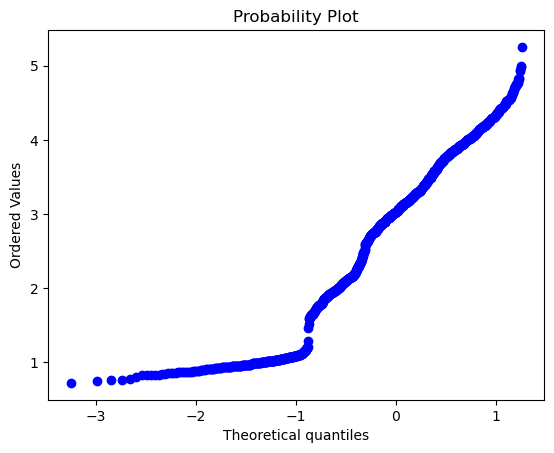

<Figure size 640x480 with 0 Axes>

In [202]:
# check normality with qq plot
from scipy import stats

stats.probplot(df1.JobSatisfaction, plot=plt)
plt.figure()

In [203]:
df1.BusinessTravel.value_counts()

BusinessTravel
Travel_Rarely        719
Travel_Frequently    224
Non-Travel           123
Name: count, dtype: int64

In [204]:
stats.shapiro(df1.JobSatisfaction)

ShapiroResult(statistic=nan, pvalue=1.0)

In [205]:
# H0: data comes from normal distribution
# H1: data does not come from normal distribution

# test not performed
stats.shapiro(df1.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"])

ShapiroResult(statistic=nan, pvalue=1.0)

In [206]:
df.JobSatisfaction.shape

(1470,)

In [207]:
rarely = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Rarely"]
frequently = df.JobSatisfaction[df["BusinessTravel"]=="Travel_Frequently"]
nontravel = df.JobSatisfaction[df["BusinessTravel"]=="Non-Travel"]

In [208]:
#H0: equal variances
#H1: non equal variances

from scipy.stats import levene

levene(rarely, frequently, nontravel, center = "mean")

LeveneResult(statistic=nan, pvalue=nan)

In [209]:
# normality confirmed so can perform anova

# H0: mu is equal amongst groups
# H1: at least one mu is different

from statsmodels.formula.api import ols
import statsmodels.api as sm

In [210]:
# model
model = ols("JobSatisfaction~BusinessTravel", data=df).fit()

# anova linear model
aov = sm.stats.anova_lm(model, type=2)
print(aov)

# accept H0 in this situation

                    df       sum_sq   mean_sq        F    PR(>F)
BusinessTravel     2.0     3.189243  1.594621  1.21763  0.296301
Residual        1184.0  1550.579642  1.309611      NaN       NaN


### 4.3 Use a Jupyter notebook to produce result sets from the provided dataset, such as scatter plots or regression models. Provide a summary of your findings.

In [211]:
## tables of results for statistical analysis
# can examine linear relationships of numeric features

# results from anova and normality testing

# results from chi2 

# results from baseline class?

In [212]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.920786,Yes,Travel_Rarely,990.110009,Sales,1.016716,1.770313,Life Sciences,1.033298,1.054148,...,1.012832,95.612654,0.000000,8.063833,0.000000,1.052104,5.795945,3.993896,0.000000,4.594972
1,51.589037,No,Travel_Frequently,276.776030,Research & Development,NaN,1.035333,Life Sciences,0.944859,2.107031,...,4.312008,85.370868,1.104642,8.965059,3.264952,2.526470,10.070232,7.937505,1.032295,5.901207
2,33.131540,Yes,Travel_Rarely,1204.158501,Research & Development,2.198662,2.118801,Other,0.810809,4.008125,...,2.332558,76.248084,0.000000,8.427238,3.004521,2.924784,0.000000,0.000000,0.000000,0.000000
3,34.707073,No,Travel_Frequently,1352.752432,Sales,2.937851,3.670674,Life Sciences,0.822976,4.587269,...,3.029591,75.888697,0.000000,7.662606,2.856001,3.117053,8.435324,5.563667,2.845429,0.000000
4,24.790188,No,Travel_Rarely,485.053333,Research & Development,1.988953,1.120496,Medical,NaN,7.228740,...,NaN,72.670937,0.953012,6.241733,2.814719,3.112317,2.040124,1.970786,2.495949,2.219353


In [213]:
# below modelling with linear regression is used to explore the assumption that there is a lack of clear linear relationships between the features
# the coefficient of the linear regression line provides a metric to understand the linear relationship between two variables
# when viewed with correlation of the variables provides further insight into the type of relationships between the features
# assuming the relationships will be weak, polynomial features will be examined hoping to highlight some non linear relationships that could aid modelling

# there are some slight curves in the lines below but maybe not prominent enough to warrant inclusion in modelling...
# ...plus more data points obscure their expression

# this used the original dataset removing the null each time.. similar results are got with the prepared dataset

# when modelled are their differences in the targets?



#PerformanceRating
#JobSatisfaction

In [214]:
from sklearn.preprocessing import PolynomialFeatures

In [215]:
def linear_relationship_explore(df, v1="PerformanceRating"):
    v1 = v1

    for i in df.columns:
        _ = df.copy()
        try:   
            v2 = i
            if v1 == v2:
                pass
            else:
                    
                _ = _.dropna(subset=[v1, v2])
                
                # plotting subset
                _ = _.iloc[:200,:]
                
                plt.scatter(_[v1], _[v2])
                
                # Adding labels and a title
                plt.xlabel(v1)
                plt.ylabel(v2)
                plt.title('Scatter Plot of Two Variables')
                
                # Fit a linear regression line
                slope, intercept = np.polyfit(_[v1], _[v2], 1)
                print(slope)
                plt.plot(_[v1], slope * _[v1] + intercept, color='red')
                
                
                # Display the plot
                plt.show()
            
            
            
                degree = 3  # Adjust the degree as needed
                model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
                
                X = _[[v1]].values.reshape(-1, 1)
                y = _[v2]
                
                # Fit the model
                model.fit(X, y)
                
                # Plotting the data and the model
                plt.scatter(_[v1], _[v2])
                plt.plot(_[v1], model.predict(X), color='red')
                
                coefficients = model.named_steps['linearregression'].coef_
                
                # Intercept (constant term)
                intercept = model.named_steps['linearregression'].intercept_
                
                print("Coefficients:", coefficients)
                print("Intercept:", intercept)
                
                # Adding labels and a title
                plt.xlabel(v1)
                plt.ylabel(v2)
                plt.title('Polynomial Regression')
                
                # Display the plot
                plt.show()
        except:
            pass
        

1.0625380740814756


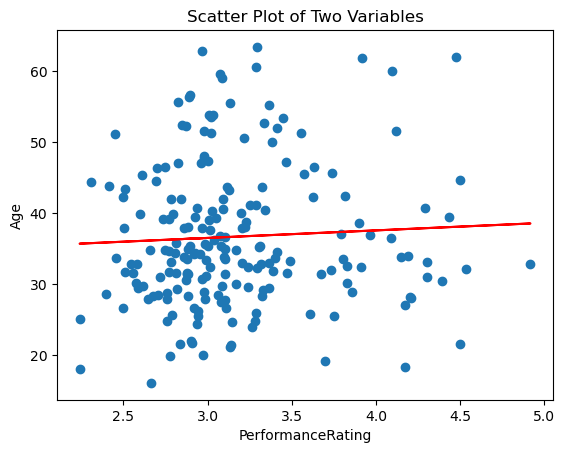

-52.238011280078


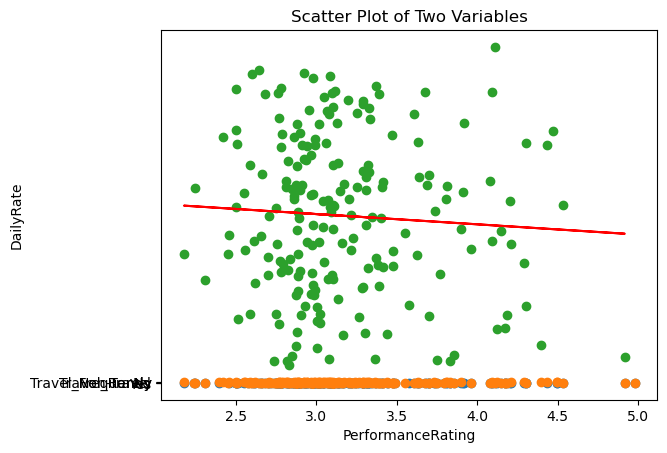

-1.1204176589756


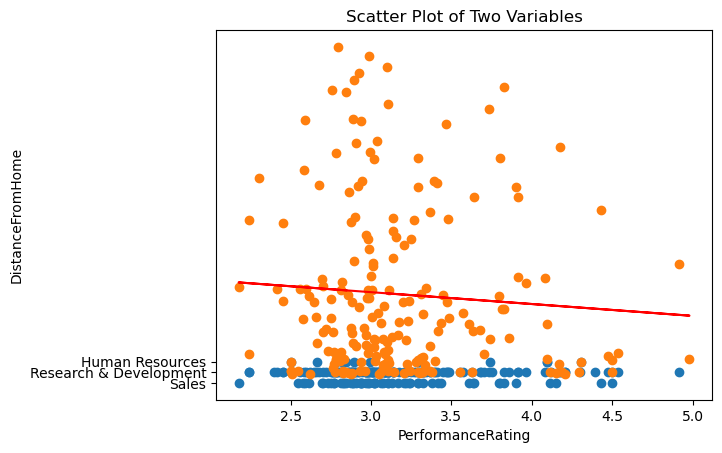

0.03278971213428034


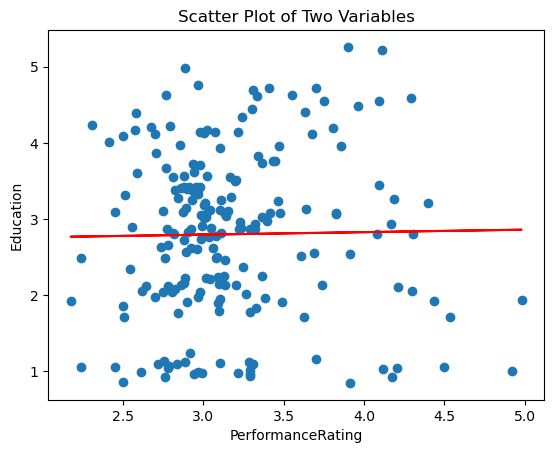

-0.012322272573598709


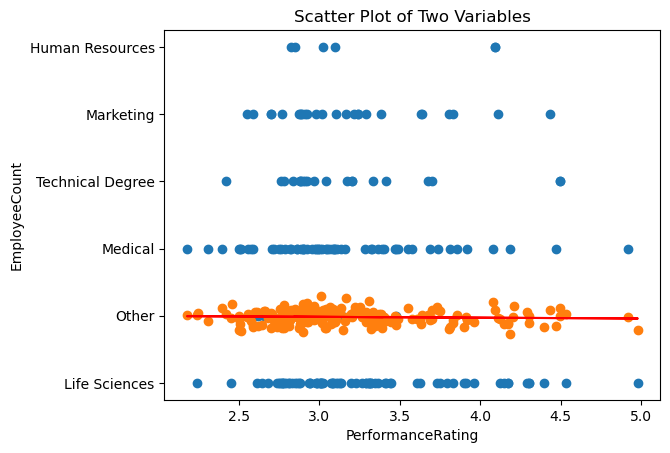

-14.88616159635823


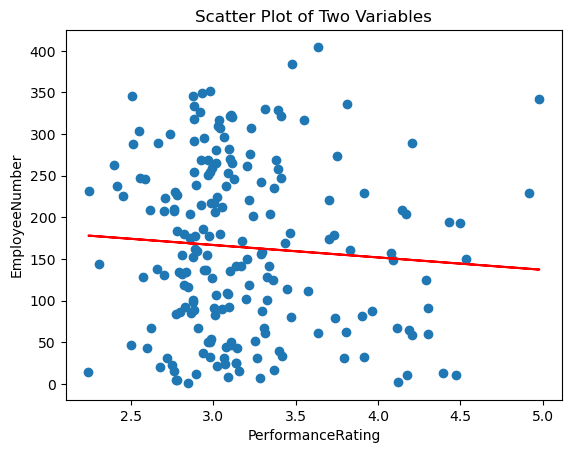

-0.3916172281206093


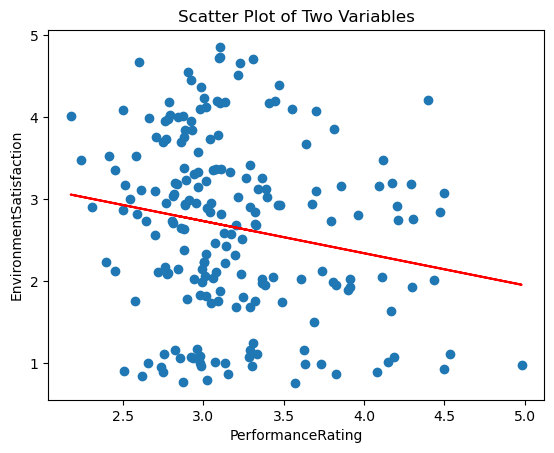

-1.6331801531312324


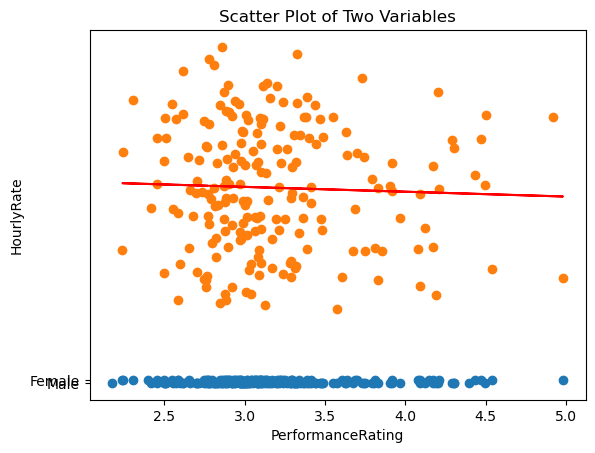

-0.10563018301709377


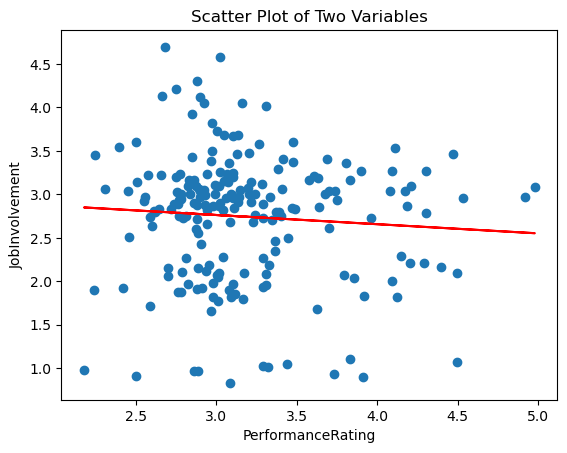

-0.13573957302731582


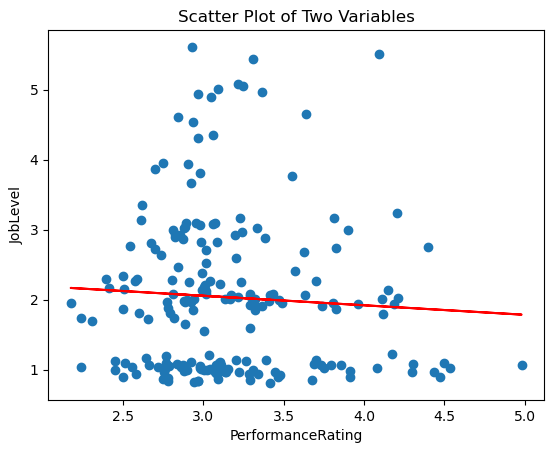

-0.010091693018078088


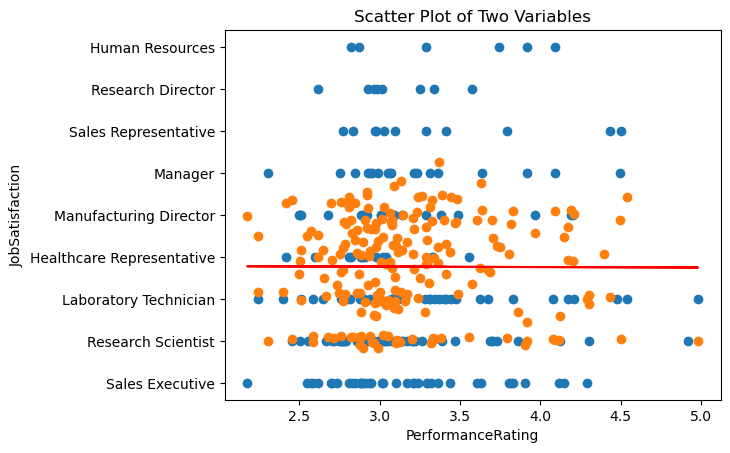

-22.072072822115565


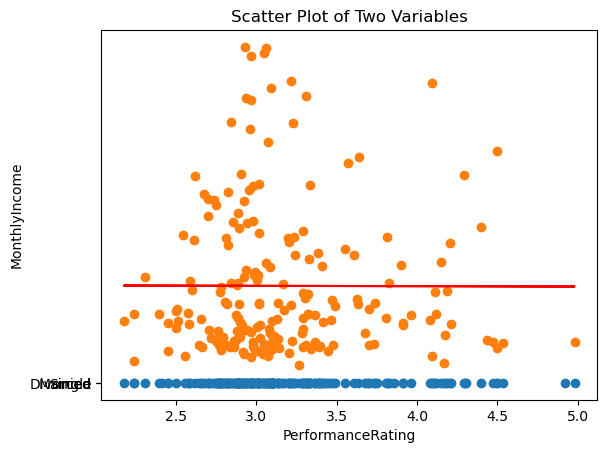

-1076.5959539973794


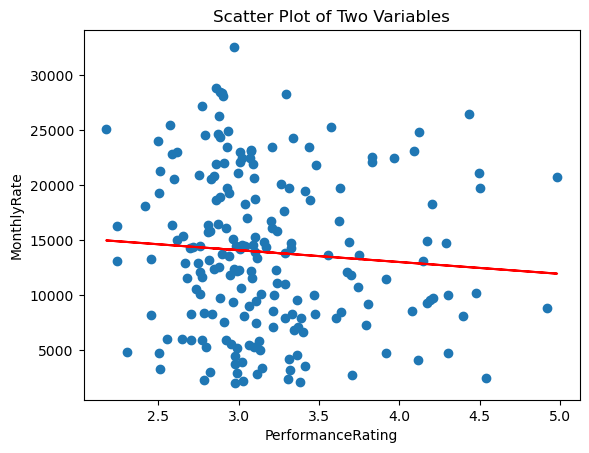

0.6421331520168811


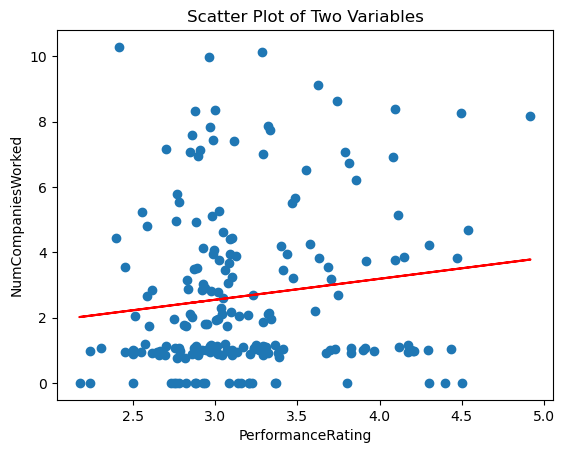

4.929324076513791


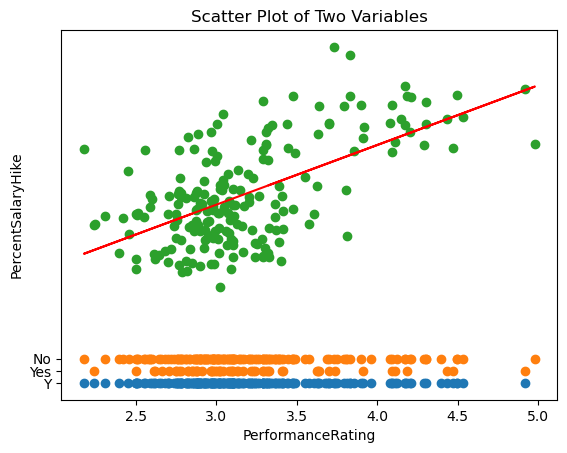

-0.15554071771861874


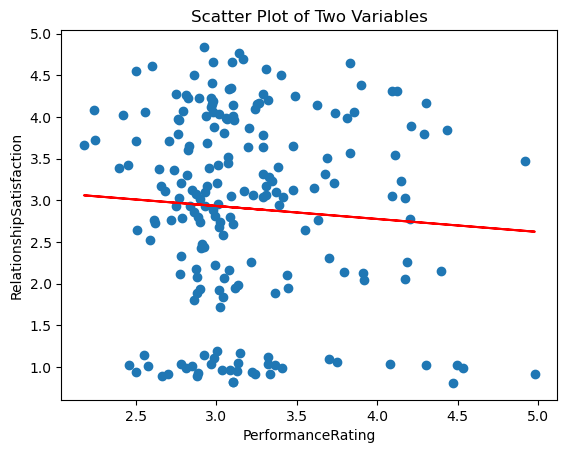

-0.280645674230347


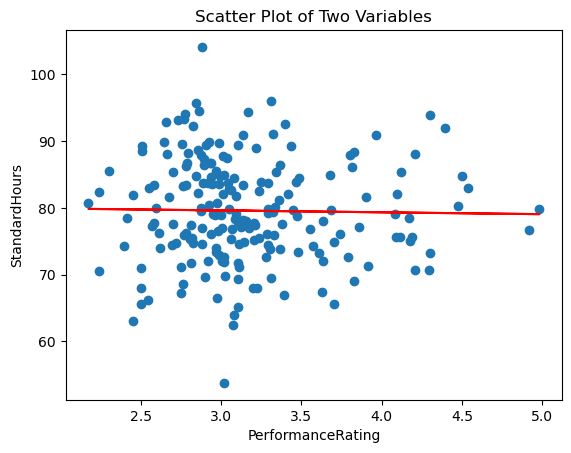

0.014040768640083938


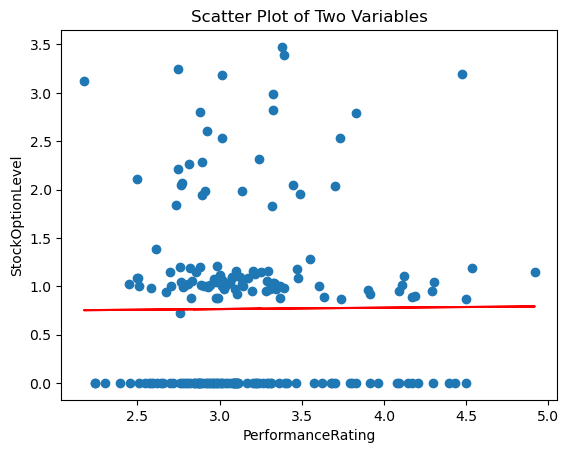

0.2684422970409966


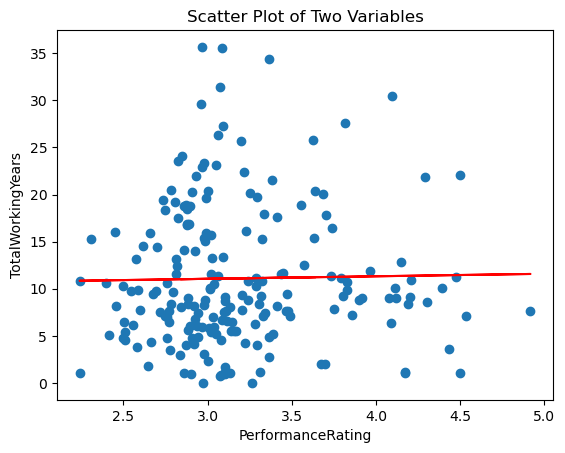

-0.11193690749474852


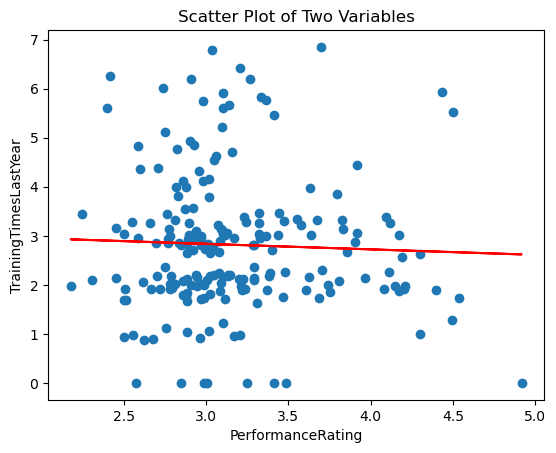

0.07865274702283663


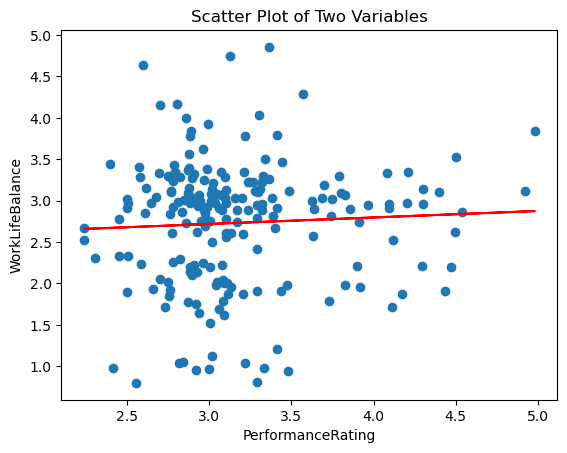

0.2656212598771654


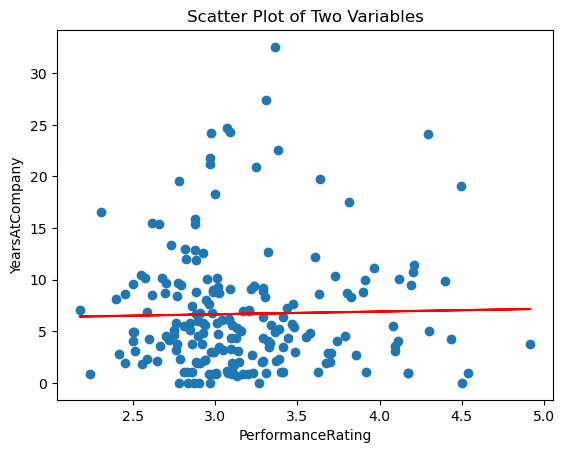

-0.45250933550225697


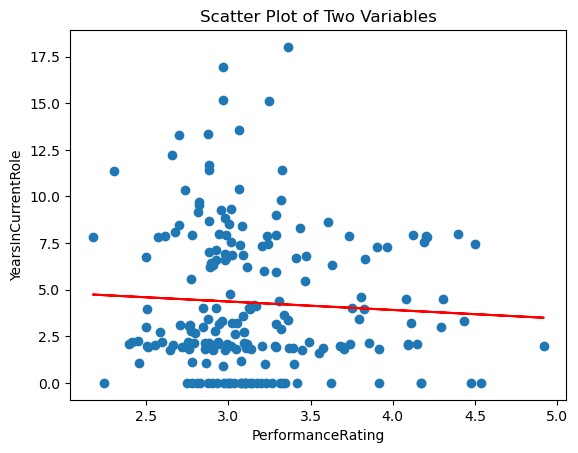

0.2718088925493525


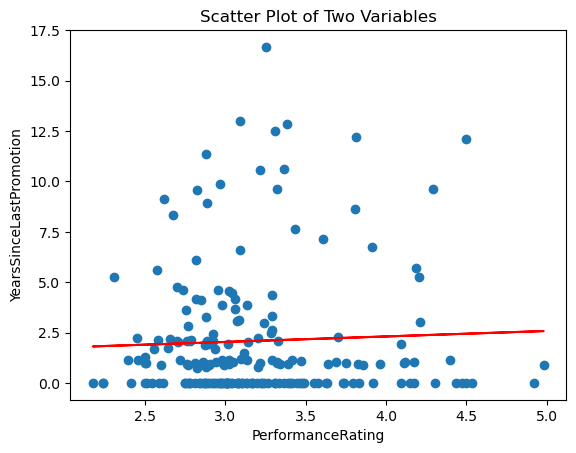

-0.4958541382737103


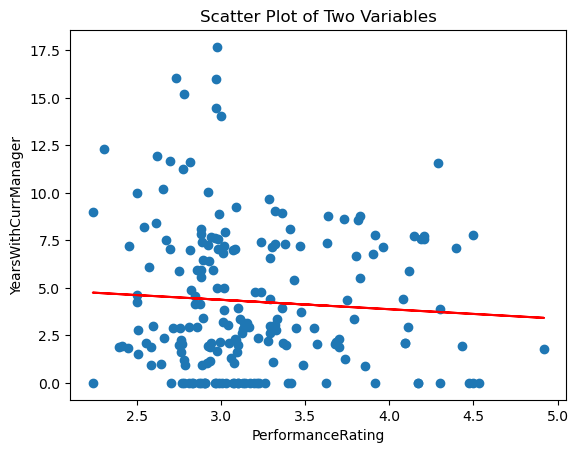

In [216]:
# model both interested features
linear_relationship_explore(df)

In [217]:
#from sklearn.preprocessing import PolynomialFeatures

#degree = 3  # Adjust the degree as needed
#model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

#X = _[[v1]].values.reshape(-1, 1)
#y = _[v2]

# Fit the model
#model.fit(X, y)

# Plotting the data and the model
#plt.scatter(_[v1], _[v2])
#plt.plot(_[v1], model.predict(X), color='red')

#coefficients = model.named_steps['linearregression'].coef_

# Intercept (constant term)
#intercept = model.named_steps['linearregression'].intercept_

#print("Coefficients:", coefficients)
#print("Intercept:", intercept)

# Adding labels and a title
#plt.xlabel('Variable X')
#plt.ylabel('Variable Y')
#plt.title('Polynomial Regression')

# Display the plot
#plt.show()

In [218]:
#df[v1].corr(df[v2])

## 5. Module: Machine Learning

### 5.1. 

In [219]:
# machine learning trial
# class function may be not working right.. or data is really bad

# some progress has been seen classifying JobSatisfaction...
# ...PerformanceRating has been lacking all round...


### 5.2. Machine Learning models can be used for Prediction, Classification, and Clustering. You can choose features for the machine learning models based on feature selection methods, such as random or any other method. The selection of hyperparameters for the ML models should be performed using hyperparameter tuning, such as GridSearchCV. Obtain the best accuracy using optimal values the hyperparameters.

In [220]:
# using best features from data preparation

In [221]:
X
y

array([1, 0, 1, ..., 0, 0, 0])

In [222]:
# col type
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include='number').columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('pca', PCA(0.995)),
    ('lda', LDA()),
    ('classifier', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Use RandomUnderSampler separately
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Fit the pipeline on the resampled data
pipeline.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6188679245283019
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.72       213
           1       0.28      0.62      0.39        52

    accuracy                           0.62       265
   macro avg       0.58      0.62      0.56       265
weighted avg       0.75      0.62      0.66       265



In [223]:
# Assuming y_test is a NumPy array
y_test_counts = np.unique(y_test, return_counts=True)

# y_test_counts is a tuple where the first element contains unique values and the second element contains their counts
unique_values, counts = y_test_counts

# Print the unique values and their counts
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")


Value: 0, Count: 213
Value: 1, Count: 52


In [224]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Assuming X is your feature matrix and y is the target variable
# Adjust column names based on your dataset
categorical_columns = X.select_dtypes(include='object').columns
numerical_columns = X.select_dtypes(include='number').columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create transformers for numerical and categorical columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Create an imbalanced-learn pipeline with undersampling
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('lda', LDA()),
    #('sampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression())
])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  # Regularization penalty type
    'classifier__solver': ['liblinear', 'lbfgs', 'saga'],  # Solver for optimization
    'classifier__max_iter': [100, 200, 300],  # Maximum number of iterations
    #'lda__n_components': [None, 2, 3],  # Number of components for LDA
    #'sampler__sampling_strategy': ['auto', 0.5, 0.7],  # Sampling strategy for RandomUnderSampler
}

# Create GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')


# Use RandomUnderSampler separately
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Fit the grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Model Accuracy: 0.6490566037735849
Best Hyperparameters:
{'classifier__C': 0.001, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       213
           1       0.31      0.65      0.42        52

    accuracy                           0.65       265
   macro avg       0.60      0.65      0.59       265
weighted avg       0.77      0.65      0.68       265



In [225]:
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomUnderSampler(random_state=42)

X_sampled, y_sampled = sampler.fit_resample(X, y)

In [227]:
#y_sampled.value_counts()

In [228]:
X_sampled.isnull().sum()

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [229]:
from sklearn.model_selection import train_test_split




# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (412, 31)
X_test shape: (104, 31)
y_train shape: (412,)
y_test shape: (104,)


In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tree = model.predict(X_test)

# Evaluate the model
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print("Decision Tree - Accuracy:", accuracy_tree)


ValueError: could not convert string to float: 'Travel_Rarely'

In [231]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

# Classification Report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


ValueError: could not convert string to float: 'Travel_Rarely'

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
accuracy_tree = accuracy_score(y_test, y_pred_tree)

print("Decision Tree - Accuracy:", accuracy_tree)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest - Accuracy:", accuracy_rf)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# K-Nearest Neighbors Classifier
#knn_model = KNeighborsClassifier()
#knn_model.fit(X_train, y_train)
#y_pred_knn = knn_model.predict(X_test)
#accuracy_knn = accuracy_score(y_test, y_pred_knn)
#print("K-Nearest Neighbors - Accuracy:", accuracy_knn)

# Support Vector Classifier (SVC)
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Support Vector Classifier - Accuracy:", accuracy_svc)

# Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes - Accuracy:", accuracy_nb)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting - Accuracy:", accuracy_gb)
